In [321]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
from tqdm import tqdm
from copy import copy
import rasterio
from contextlib import contextmanager
from rasterio import MemoryFile
import networkx as nx
import powerlaw
import seaborn as sns
import scipy as sc
import random

In [322]:
def get_temporal_df(df, temporal_scale):
    if temporal_scale == 1:
        return df
    else:
        new_df = []
        
        for val in np.arange(0, len(df), temporal_scale):
            if val+temporal_scale > len(df):
                break
            else:
                tmp = [" ".join(df.iloc[val: val+temporal_scale, 0])]
                tmp.extend(list(df.iloc[val: val+temporal_scale, 1:].sum(axis=0)))
                new_df.append(tmp)

        new_df = pd.DataFrame(new_df)
        new_df.columns = df.columns
        
        return new_df
    
def get_gdp_differential(df):
    new_df = []
    for i in range(1, len(df)):
        tmp = [df.iloc[i-1, :][0] + "-" + df.iloc[i, :][0]]
        tmp.extend(100.0*(df.iloc[i, :][1:] - df.iloc[i-1, :][1:])/df.iloc[i-1, :][1:])
        new_df.append(tmp)
    
    return pd.DataFrame(new_df, columns=list(df.columns)[0:])

In [577]:
g = nx.Graph()
g.add_nodes_from((1,2,3,4,5))
# a = [(1,2, {"1": 20, "2": 30})]
# a = []
g.add_edges_from([(1,2,{"weight": 10**3}), (1,3,{"weight": 10**3}), (2,3,{"weight":10**3}), (3,4,{"weight": 10**3}), (4,5,{"weight": 10**3})])
# print(g._adj)
print(list(nx.closeness_centrality(g, distance='weight').values()))
# list(nx.clustering(g, weight="weight").values())

[0.0005714285714285715, 0.0005714285714285715, 0.0008, 0.0006666666666666666, 0.00044444444444444447]


In [933]:
def get_graph_analysis(all_radius, all_temporal, seeds, events_data=False,first_derivative=True, 
                       plot=False, threshold=0.0, base_data=False):
    if plot:
        assert len(seeds) == 1, "More than one seed given for plotting. Give only one seed."
    all_closeness, all_closeness_base = {}, {}
    all_clustering, all_clustering_base = {}, {}
    for radius in tqdm(all_radius):
        for seed in seeds:
            if not events_data:
                df = pd.read_csv("../data/results/gdp_{}_{}.csv".format(radius, seed))
                df.rename(columns={"Unnamed: 0": "year_month"},  inplace=True)
            
            if plot:
                fig, axes = plt.subplots(1, len(all_temporal), figsize=(15, 5), sharey=True)
            
            for k, temporal_scale in enumerate(all_temporal):
                if events_data:
                    df_copy = pd.read_csv("../data/results/events/gdp_{}_{}_{}_events.csv".format(
                        radius, temporal_scale, seed))
                else:
                    df_copy = df.copy(deep=True)
                    df_copy = get_temporal_df(df_copy, temporal_scale)

                    if first_derivative:
                        df_copy = get_gdp_differential(df_copy)
            
                corr_dict = df_copy.corr(method="pearson").dropna(how='all',axis=1).dropna(how="all", axis=0).to_dict()
                
                if base_data:
                    G_closeness_base = nx.Graph()
                    G_clustering_base = nx.Graph()
                    
                G1 = nx.Graph()
                G2 = nx.Graph()
                nodes = list(corr_dict.keys())
#                 nrows = len(nodes)//5
#                 counter_row, counter_column = 0, 0
#                 for node in nodes:
#                     pos = (counter_row, counter_column)
#                     G.add_node(node, pos=pos)
#                     counter_row += 1
#                     if counter_row == 5:
#                         counter_row = 0
#                         counter_column += 1

                if base_data:
                    G_closeness_base.add_nodes_from(nodes)
                    G_clustering_base.add_nodes_from(nodes)
                
                G1.add_nodes_from(nodes)
                G2.add_nodes_from(nodes)

                edges_closeness_base, edges_clustering_base, edges1, edges2 = [], [], [], []
                for i in range(0, len(nodes)):
                    for j in range(i+1, len(nodes)):
                        if base_data:
                            weight_closeness_base = 10**3
                            if i == 0 and j == 1:
                                weight_clustering_base = 1.0 #assigned a value of 1 so that the normalised weight remains the same.
                            else:
                                weight_clustering_base = 10**-3
                            
                            edges_closeness_base.append((nodes[i],nodes[j], weight_closeness_base))
                            edges_clustering_base.append((nodes[i],nodes[j], weight_clustering_base))
                        
                        corr = abs(corr_dict[nodes[i]][nodes[j]])
                        if corr >= threshold:
                            if corr == 0.0:
                                weight1 = 10**3
                                weight2 = 0.0
                            else:
                                weight1 = 1.0/corr
                                weight2 = corr
                        else:
                            continue
                            
                        edges1.append((nodes[i], nodes[j], weight1))
                        edges2.append((nodes[i], nodes[j], weight2))
#                         edges.append((nodes[i], nodes[j], {"inverse_corr": weight1}))
#                 G.add_weighted_edges_from(edges, weight="inverse_corr")
                if base_data:
                    G_closeness_base.add_weighted_edges_from(edges_closeness_base, weight="base_weight")
                    G_clustering_base.add_weighted_edges_from(edges_clustering_base, weight="base_weight")
                
                G1.add_weighted_edges_from(edges1, weight="inverse_corr")
                G2.add_weighted_edges_from(edges2, weight="corr")
                
                if base_data:
                    closeness_base_data = list(nx.closeness_centrality(G_closeness_base, 
                                                                               distance='base_weight').values())
                    closeness_base_mean = np.mean(closeness_base_data)
                    all_closeness_base[(radius, temporal_scale, seed)] = closeness_base_mean

                    clustering_base_data = list(nx.clustering(G_clustering_base, weight='base_weight').values())
                    clustering_base_mean = np.mean(clustering_base_data)
                    all_clustering_base[(radius, temporal_scale, seed)] = clustering_base_mean


                closeness_data = list(nx.closeness_centrality(G1, distance='inverse_corr').values())
                closeness_mean = np.mean(closeness_data)
                all_closeness[(radius, temporal_scale, seed)] = closeness_mean

                clustering_data = list(nx.clustering(G2, weight='corr').values())
                clustering_mean = np.mean(clustering_data)
                all_clustering[(radius, temporal_scale, seed)] = clustering_mean
    
            
#                 pos=nx.get_node_attributes(G,'pos')
#                 nx.draw(G, pos)
#                 all_edges = list(G.edges)
#                 chosen_edges = random.choices(all_edges, k=40)
                    
                    
#                 nx.draw_networkx_edges(G, pos, edgelist=chosen_edges)
#                 labels = nx.get_edge_attributes(G,'weight')
#                 nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
#                 return
    
            if plot:
                sns.kdeplot(closeness_data, ax=axes[k], linestyle="--")
                axes[k].set_title("Spatial: {}, temporal: {}".format(radius, temporal_scale))
                axes[k].set_xlabel("closeness centrality")
            
                if events_data:
                    save_filename = "../data/pictures/corr_closeness_distribution_{}_{}_{}.png".format("events_data", radius, seed)
                else:
                    save_filename = "../data/pictures/corr_closeness_distribution_{}_{}.png".format(radius, seed)

                plt.savefig(save_filename, bbox_inches='tight')
    
    all_closeness_mean, all_closeness_base_mean = {}, {}
    all_clustering_mean, all_clustering_base_mean = {}, {}
    for radius in all_radius:
        for temporal_scale in all_temporal:
            tmp1, tmp2, tmp3, tmp4 = [], [], [], []
            for seed in seeds:
                tmp1.append(all_closeness[(radius, temporal_scale, seed)])
                tmp2.append(all_clustering[(radius, temporal_scale, seed)])
                
                if base_data:
                    tmp3.append(all_closeness_base[(radius, temporal_scale, seed)])
                    tmp4.append(all_clustering_base[(radius, temporal_scale, seed)])
                
            all_closeness_mean[(radius, temporal_scale)] = (np.mean(tmp1), sc.stats.sem(tmp1))
            all_clustering_mean[(radius, temporal_scale)] = (np.mean(tmp2), sc.stats.sem(tmp2))
            
            if base_data:
                all_closeness_base_mean[(radius, temporal_scale)] = (np.mean(tmp3), sc.stats.sem(tmp3))
                all_clustering_base_mean[(radius, temporal_scale)] = (np.mean(tmp4), sc.stats.sem(tmp4))
    if base_data:
        return all_closeness_mean, all_clustering_mean, all_closeness_base_mean, all_clustering_base_mean
    else:
        return all_closeness_mean, all_clustering_mean

In [934]:
def plot_heatmap(network_metric_data, all_radius, all_temporal, first_derivative=True, mean=True, 
                 events_data=False, threshold=0.0, clustering_data=False):
    idx = 1 if not mean else 0
    stds = []
    for radius in all_radius:
        tmp = []
        for temporal in all_temporal:
            tmp.append(network_metric_data[(radius, temporal)][idx])
        stds.append(tmp)
    stds = np.array(stds)
    stds = np.flip(stds, axis=0)
    
    default_x_ticks = range(len(all_temporal))
    default_y_ticks = range(len(all_radius))

    plt.figure(figsize=(5,6))

    plt.xticks(default_x_ticks, all_temporal)
    plt.yticks(default_y_ticks, all_radius[::-1])

    plt.xlabel("temporal scale")
    plt.ylabel("spatial scale")
    plt.imshow(stds)
    plt.savefig("../data/pictures/correlation_{}_at_scales_{}_{}_{}_threshold-{}.png".format(
        "clustering" if clustering_data else "closeness", "events" if events_data else "_", 
        "derivative" if first_derivative else "absolute", "mean" if mean else "std", threshold), 
                bbox_inches='tight')
    
def create_graph_analysis_df(data, data_type="closeness", threshold=threshold, base_data=False):
    df_data, df_data2 = [], []
    for radius in all_radius:
        tmp, tmp2 = [], []
        for temporal in all_temporal:
            tmp.append(round(data[(radius, temporal)][0], 2))
            tmp2.append(round(data[(radius, temporal)][1], 2))
        df_data.append(tmp)
        df_data2.append(tmp2)

    df = pd.DataFrame(df_data, columns=[all_temporal])
    df2 = pd.DataFrame(df_data2, columns=[all_temporal])
    df.index = all_radius
    df2.index = all_radius
    
    if base_data:
        df.to_csv("../data/correlation_based_{}_base_events_data.csv".format(data_type))
        df2.to_csv("../data/correlation_based_{}_base_events_data_std.csv".format(data_type))
    else:
        df.to_csv("../data/correlation_based_{}_threshold-{}_events_data.csv".format(data_type, threshold))
        df2.to_csv("../data/correlation_based_{}_threshold-{}_events_data_std.csv".format(data_type, threshold))
    return df

### Interesting pattern noted in all_closeness correlation for events data closeness. It decreases as scale increases but only uptil 12 months scale after that it always increase. Meaning there is a tipping point between 12 and 60.

In [935]:
all_temporal = [1, 4, 12, 60]
all_radius = [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]
seeds = [1,2,3,4,5]
events_data = True
plot=False
thresholds=[0.0, 0.3, 0.6, 0.8]

In [936]:
for i, threshold in enumerate(tqdm(thresholds)):
    if i== 0:
        all_closeness_mean, all_clustering_mean, all_closeness_base_mean, all_clustering_base_mean = get_graph_analysis(
            all_radius, all_temporal, seeds, events_data=events_data, plot=plot, threshold=threshold, base_data=True)
        
        _ = create_graph_analysis_df(all_closeness_base_mean, data_type="closeness", threshold=threshold, base_data=True)
        _ = create_graph_analysis_df(all_clustering_base_mean, data_type="clustering", threshold=threshold, base_data=True)
    else:
        all_closeness_mean, all_clustering_mean = get_graph_analysis(all_radius, all_temporal, seeds, events_data=events_data, plot=plot, 
                                               threshold=threshold)
    
    df1 = create_graph_analysis_df(all_closeness_mean, data_type="closeness", threshold=threshold)
    df2 = create_graph_analysis_df(all_clustering_mean, data_type="clustering", threshold=threshold)    

100%|████████████████████████████████████████████| 4/4 [06:40<00:00, 100.01s/it]


In [938]:
# x = [1,2,3,4]
# y = [10, 13, 15, 12]
# under_line = [_-(_+1)*2 for _ in y] 
# over_line = [_+(_+1)*2 for _ in y] 
# plt.plot(x, y)
# plt.fill_between(x, under_line, over_line, color='b', alpha=.1)
# # plt.plot(x, under_line)
# # plt.plot(x, over_line)
# np.std(x), sc.stats.sem(x)
# 1.11803/np.sqrt(3)

/home/ankur/miniconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/ankur/miniconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


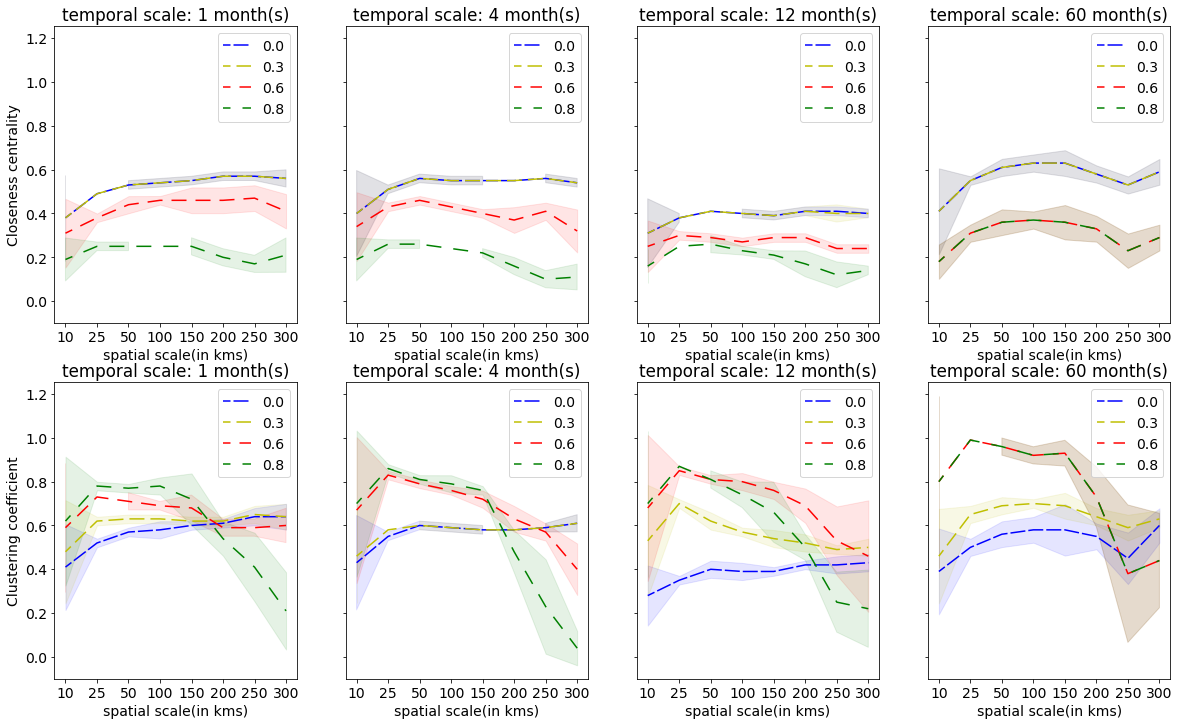

In [945]:
# fig, axes = plt.subplots(2, len(thresholds), figsize=(15, 9), sharey=True)
# for i, threshold in enumerate(thresholds):
#     df1 = pd.read_csv("../data/correlation_based_closeness_threshold-{}_events_data.csv".format(threshold))
#     df2 = pd.read_csv("../data/correlation_based_clustering_threshold-{}_events_data.csv".format(threshold))
    
#     data1 = np.array(df1.iloc[:, 1:])
#     data2 = np.array(df2.iloc[:, 1:])
    
#     default_x_ticks = range(len(all_temporal))
#     default_y_ticks = range(len(all_radius))

#     axes[0][i].set_xticks(default_x_ticks, all_temporal)
#     axes[0][i].set_yticks(default_y_ticks, all_radius)
    
#     axes[1][i].set_xticks(default_x_ticks, all_temporal)
#     axes[1][i].set_yticks(default_y_ticks, all_radius)
    
#     if i == 0:
#         axes[0][i].set_ylabel("spatial scale")
        
#     axes[0][i].set_title("closeness, threshold: {}".format(threshold))
#     axes[0][i].imshow(data1)
    
    
#     axes[1][i].set_xlabel("temporal scale")
#     if i == 0:
#         axes[1][i].set_ylabel("spatial scale")
#     axes[1][i].set_title("clustering, threshold: {}".format(threshold))
#     axes[1][i].imshow(data2)
    
    
all_closeness_data_mean, all_closeness_data_std = {}, {}
all_clustering_data_mean, all_clustering_data_std = {}, {}

for threshold in thresholds:
    df1 = pd.read_csv("../data/correlation_based_closeness_threshold-{}_events_data.csv".format(threshold))
    df2 = pd.read_csv("../data/correlation_based_clustering_threshold-{}_events_data.csv".format(threshold))
    
    df3 = pd.read_csv("../data/correlation_based_closeness_threshold-{}_events_data_std.csv".format(threshold))
    df4 = pd.read_csv("../data/correlation_based_clustering_threshold-{}_events_data_std.csv".format(threshold))
    
    for temporal_scale in all_temporal:
        spatial_data1 = list(df1[str(temporal_scale)])
        spatial_data2 = list(df2[str(temporal_scale)])
        spatial_data3 = list(df3[str(temporal_scale)])
        spatial_data4 = list(df4[str(temporal_scale)])
        
        all_closeness_data_mean[(temporal_scale, threshold)] = spatial_data1
        all_clustering_data_mean[(temporal_scale, threshold)] = spatial_data2
        all_closeness_data_std[(temporal_scale, threshold)] = spatial_data3
        all_clustering_data_std[(temporal_scale, threshold)] = spatial_data4
     
    
fig, axes = plt.subplots(2, len(all_temporal), figsize=(20, 12), sharey=True)

x = np.arange(len(all_radius))
colors = ['b', 'y', 'r', 'g']
default_x_ticks = range(len(all_radius))
for i, temporal_scale in enumerate(all_temporal):
    for j, threshold in enumerate(thresholds):
        y1 = all_closeness_data_mean[(temporal_scale, threshold)]
        y2 = all_clustering_data_mean[(temporal_scale, threshold)]
        y3 = all_closeness_data_std[(temporal_scale, threshold)]
        y4 = all_clustering_data_std[(temporal_scale, threshold)]
        
        under_line1, under_line2 = [], []
        over_line1, over_line2 = [], []
        
        for m in range(len(y3)):
            ci = sc.stats.norm.interval(confidence=0.95, loc=y1[m], scale=y3[m])
            under_line1.append(ci[0])
            over_line1.append(ci[1])
            
            ci = sc.stats.norm.interval(confidence=0.95, loc=y2[m], scale=y4[m])
            under_line2.append(ci[0])
            over_line2.append(ci[1])
            

        axes[0][i].set_xticks(default_x_ticks, [int(radius) for radius in all_radius])
        axes[1][i].set_xticks(default_x_ticks, [int(radius) for radius in all_radius])
        
        axes[0][i].plot(x, y1, label="{}".format(threshold), linestyle=(5, (10, (j+1)*2)), c=colors[j])
        axes[0][i].fill_between(x, under_line1, over_line1, color=colors[j], alpha=.1)
        
        axes[1][i].plot(x, y2, label="{}".format(threshold), linestyle=(5, (10, (j+1)*2)), c=colors[j])
        axes[1][i].fill_between(x, under_line2, over_line2, color=colors[j], alpha=.1)
        
        if i == 0:
            axes[0][i].set_ylabel("Closeness centrality")
            axes[1][i].set_ylabel("Clustering coefficient")
            
        axes[0][i].set_xlabel("spatial scale(in kms)")
        axes[1][i].set_xlabel("spatial scale(in kms)")
        
        axes[0][i].set_title("temporal scale: {} month(s)".format(temporal_scale))
        axes[1][i].set_title("temporal scale: {} month(s)".format(temporal_scale))
        
        axes[0][i].legend()
        axes[1][i].legend()
        
plt.savefig("../data/pictures/correlation_closeness_and_clustering_thresholding.png", bbox_inches='tight')

        

In [748]:
# plot_heatmap(all_closeness_mean, all_radius, all_temporal, first_derivative=True, mean=True, 
#              events_data=events_data, threshold=threshold, clustering_data=False)

In [320]:
# plot_heatmap(all_clustering_mean, all_radius, all_temporal, first_derivative=True, mean=True, 
#              events_data=events_data, threshold=threshold, clustering_data=True)

In [102]:
all_closeness_mean

{(10.0, 1): (0.38057178385201007, 0.19040024239921585),
 (10.0, 4): (0.395786687705779, 0.19798213367123216),
 (10.0, 12): (0.3129716340145793, 0.15681816267760265),
 (10.0, 60): (0.40611121019179386, 0.20327904326578483),
 (25.0, 1): (0.48640410846647175, 0.008703543943070801),
 (25.0, 4): (0.5091182178138152, 0.012208203075813889),
 (25.0, 12): (0.3847337546491161, 0.016556988342336532),
 (25.0, 60): (0.5546631417626176, 0.024600293531769877),
 (50.0, 1): (0.5280281923636746, 0.02963544658046006),
 (50.0, 4): (0.5565899644638164, 0.02254310808181295),
 (50.0, 12): (0.4084876827946637, 0.007923685367761895),
 (50.0, 60): (0.6088667744509617, 0.04361244668595273),
 (100.0, 1): (0.542833963225683, 0.02916352791250242),
 (100.0, 4): (0.5476135988497309, 0.016495268125703146),
 (100.0, 12): (0.40352827216163367, 0.017213801651134765),
 (100.0, 60): (0.6292618850590828, 0.03442537876949327),
 (150.0, 1): (0.5541909752986742, 0.027060626610209953),
 (150.0, 4): (0.5477384671084419, 0.012890

In [21]:
# df = pd.read_csv("../data/results/gdp_10.0_1.csv")
# df.rename(columns={"Unnamed: 0": "year_month"},  inplace=True)

In [22]:
# heights,bins = np.histogram(df['4'],bins=40)

# heights = heights/float(sum(heights))
# binMids=bins[:-1]+np.diff(bins)/2.
# plt.plot(binMids,heights)

In [15]:
# for col in df.columns:
#     if col == "year_month":
#         continue
#     plt.plot(np.arange(len(df)), list(df[col]))

# plt.plot(np.arange(0, len(df.columns)), list(df.mean()[0:]))

### For plotting correlation adjacency matrix for different spatial and temporal scales

In [798]:
for scale in [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]:
    df = pd.read_csv("../data/results/gdp_{}_{}.csv".format(scale, 1))
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    
    for i, temporal_scale in enumerate([1, 4, 12, 60]):
        df_copy = df.copy(deep=True)
        temporal_df = get_temporal_df(df_copy, temporal_scale)
        diff_df = get_gdp_differential(temporal_df).iloc[:, 1:]
        corr_dict = diff_df.corr(method="pearson").dropna(how='all',axis=1).dropna(how="all", axis=0)
#         a = np.array(corr_dict)
#         print(np.mean(a[np.triu_indices_from(a, k=1)]))
#         break
#     break
        axes[i].imshow(corr_dict)
    plt.show()

### Plotting average correlation and std for different (r,t)

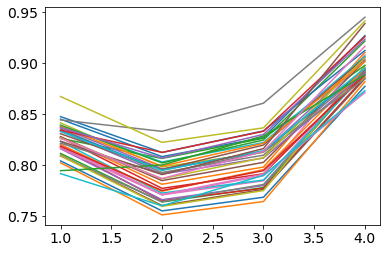

In [804]:
all_corr = {}
for scale in [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]:
    tmp_plot = []
#     fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    for i, temporal_scale in enumerate([1, 4, 12, 60]):
        tmp_mean, tmp_std = [], []
        for seed in np.arange(1, 6, 1):
            df_copy = pd.read_csv("../data/results/gdp_{}_{}.csv".format(scale, seed))
#             df_copy = df.copy(deep=True)
            temporal_df = get_temporal_df(df_copy, temporal_scale)
            diff_df = get_gdp_differential(temporal_df).iloc[:, 1:]
            corr_dict = np.array(diff_df.corr(method="pearson").dropna(how='all',axis=1).dropna(how="all", axis=0))
            corr_upper_tri = corr_dict[np.triu_indices_from(corr_dict, k=1)]
            mean, std = np.mean(corr_upper_tri),  np.std(corr_upper_tri)
            tmp_mean.append(mean)
            tmp_std.append(std)
            
        all_corr[(scale, temporal_scale)] = [np.mean(tmp_mean), np.mean(tmp_std)]
        tmp_plot.append(tmp_mean)

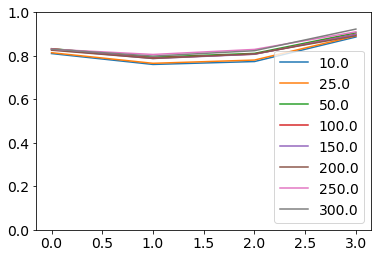

In [822]:
for spatial_scale in spatial_scales:
    tmp_plot = []
    for temporal_scale in temporal_scales:
        tmp_plot.append(all_corr[(spatial_scale, temporal_scale)][0])
    plt.plot(np.arange(len(temporal_scales)), tmp_plot, label=str(spatial_scale))
    
plt.ylim((0.0, 1.0))
plt.legend()

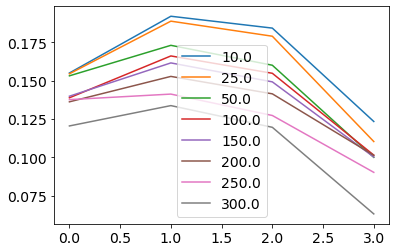

In [810]:
for spatial_scale in spatial_scales:
    tmp_plot = []
    for temporal_scale in temporal_scales:
        tmp_plot.append(all_corr[(spatial_scale, temporal_scale)][1])
    plt.plot(np.arange(len(temporal_scales)), tmp_plot, label=str(spatial_scale))
    
plt.legend()

In [821]:
for spatial_scale in spatial_scales:
    df = pd.read_csv("../data/results/gdp_{}_{}.csv".format(spatial_scale, 1))
    for temporal_scale in temporal_scales:
        df_copy  = df.copy(deep=True)
        temporal_df = get_temporal_df(df_copy, temporal_scale)
        diff_df = get_gdp_differential(temporal_df).iloc[:, 1:]
        print("{}_{}".format(spatial_scale, temporal_scale), diff_df.shape[0]*diff_df.shape[1])

10.0_1 64436
10.0_4 15928
10.0_12 5068
10.0_60 724
25.0_1 46280
25.0_4 11440
25.0_12 3640
25.0_60 520
50.0_1 13528
50.0_4 3344
50.0_12 1064
50.0_60 152
100.0_1 10324
100.0_4 2552
100.0_12 812
100.0_60 116
150.0_1 7120
150.0_4 1760
150.0_12 560
150.0_60 80
200.0_1 4984
200.0_4 1232
200.0_12 392
200.0_60 56
250.0_1 3916
250.0_4 968
250.0_12 308
250.0_60 44
300.0_1 2492
300.0_4 616
300.0_12 196
300.0_60 28


### For plotting closeness of the correlation based adjacency matrix for different spatial and temporal scales

In [9]:
all_temporal = [1, 3, 12, 60]
all_radius = [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]
seeds = [1, 2]
all_closeness_differential_mean = get_closeness_centrality(all_radius, all_temporal, seeds, first_derivative=True)

100%|█████████████████████████████████████████████| 8/8 [00:32<00:00,  4.01s/it]


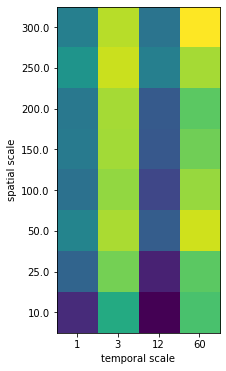

In [10]:
plot_heatmap(all_closeness_differential_mean, all_radius, all_temporal, first_derivative=True, mean=True)

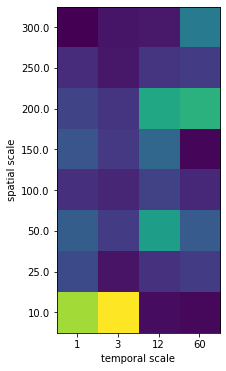

In [11]:
plot_heatmap(all_closeness_differential_mean, all_radius, all_temporal, first_derivative=True, mean=False)

In [93]:
with open("../data/voronoi_tessellation_meta_10.0_4.pkl", "rb") as f:
    data = pickle.load(f)

In [94]:
len(data["site_to_point_dict"])

180

In [213]:
all_radius = [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]
for radius in all_radius:
    seeds = [5]
    for seed in tqdm(seeds):
        with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(radius, seed), "rb") as f:
            data = pickle.load(f)
        len1 = len(data["site_to_point_dict"])

        for year in np.arange(1992, 2021, 1):
            month_range = np.arange(4, 13, 1) if year == 1992 else np.arange(1, 13, 1)
            for month in month_range:
                with open("../data/sims/{}_{}_radius-{}_seed-{}.pkl".format(year, month, radius, seed), "rb") as f:
                    data2 = pickle.load(f)

                len2 = len(data2["gdp_sum"])
                if len1 != len2:
                    print("unequal for radius: {} seed: {} year: {} and month: {}".format(radius, seed, year, 
                                                                                          month))

100%|██████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


### For plotting GDP growth distribution for different spatial and temporal scales

In [697]:
def plot_gdp_distribution(spatial_scale, temporal_scales, all_seeds, differential=True):
    fig, axes = plt.subplots(1, len(temporal_scales), figsize=(15, 5), sharey=True)
    colors = ["red", "green", "blue", "yellow", "black"]
    
    for j, temporal_scale in enumerate(temporal_scales):
        for k, seed in enumerate(all_seeds):
            df = pd.read_csv("../data/results/gdp_{}_{}.csv".format(spatial_scale, seed))
            df.rename(columns={"Unnamed: 0": "year_month"},  inplace=True)
            df_copy = df.copy(deep=True)
            df_copy = get_temporal_df(df_copy, temporal_scale)

            if differential:
                diff_df = get_gdp_differential(df_copy).iloc[:, 1:]
                data = diff_df.to_numpy().flatten()

                filtered_data = []
                for i, val in enumerate(data):
                    if not np.isnan(val):
#                         if val != 0.0:
                        filtered_data.append(val)
#                             filtered_data.append(np.log(np.abs(val)))

        #         sns.displot(filtered_data, hist=True, kde=True, bins=100, color = 'blue', 
        #                      hist_kws={'edgecolor':'black'})

                sns.kdeplot(filtered_data, color=colors[k], ax=axes[j], linestyle="--")
        axes[j].set_title("        Spatial: {}, temporal: {}".format(spatial_scale, temporal_scale))
        axes[j].set_xlabel("gdp growth rate(%)")

    #             plt.show() 


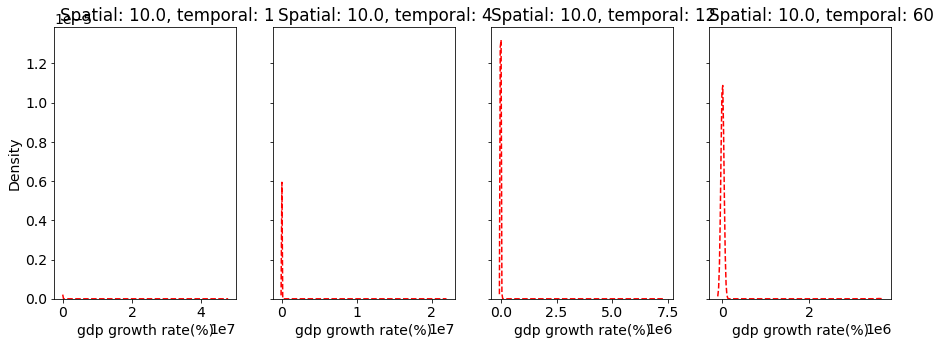

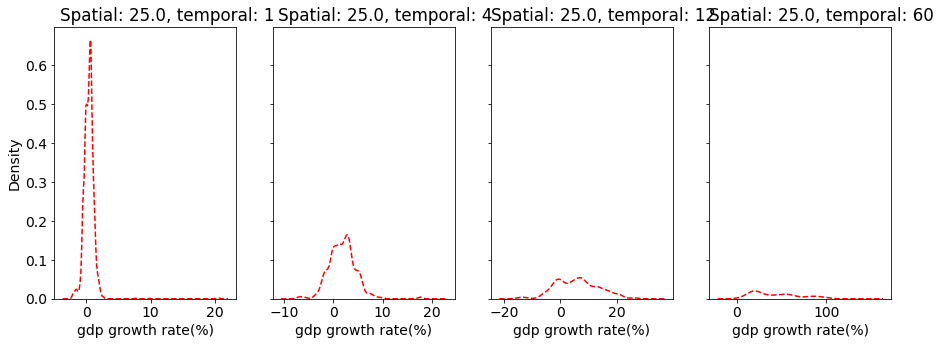

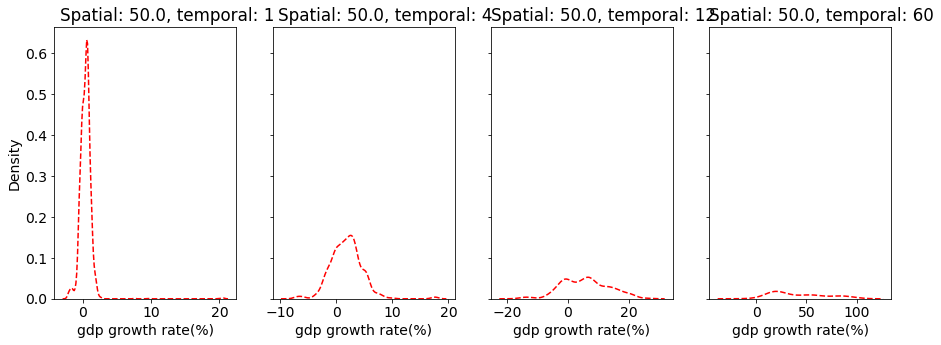

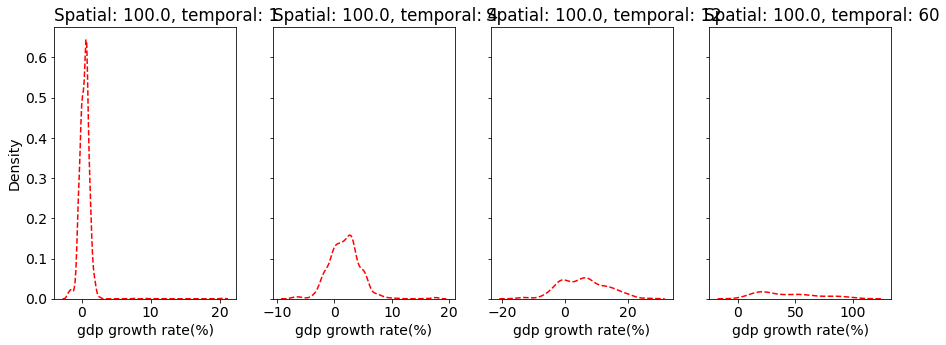

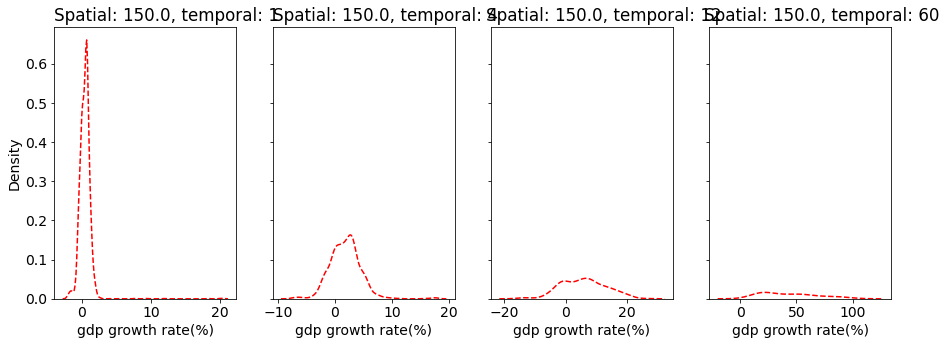

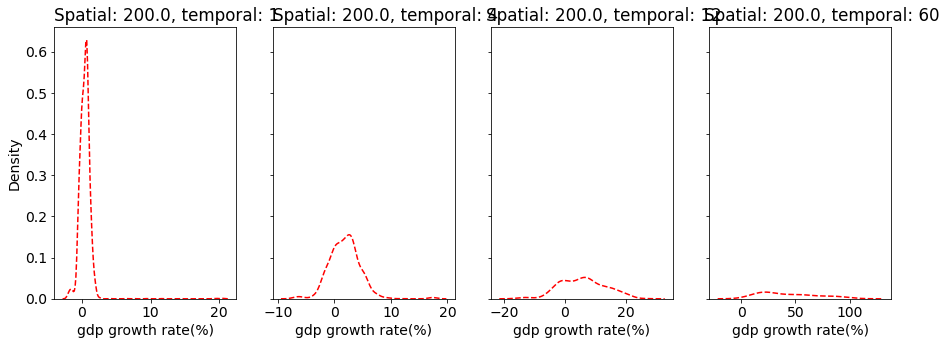

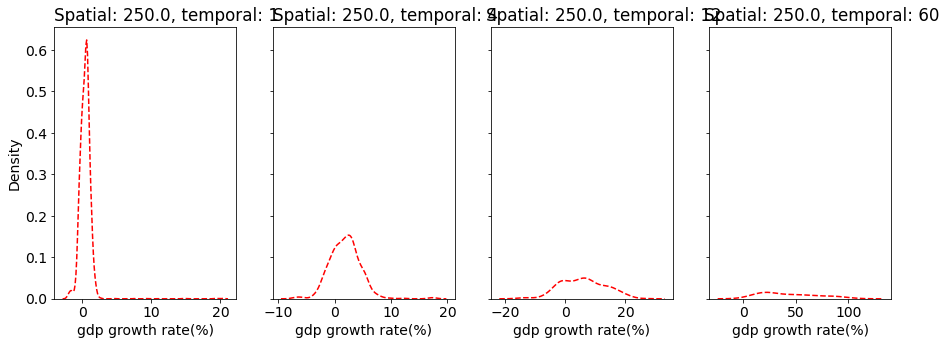

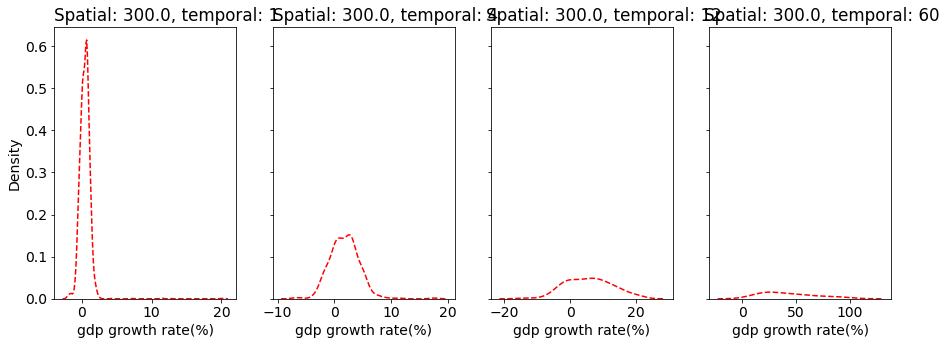

In [696]:
spatial_scales = [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]
temporal_scales = [1, 4, 12, 60]
all_seeds = np.arange(1, 2, 1)

for spatial_scale in spatial_scales:
    plot_gdp_distribution(spatial_scale, temporal_scales, all_seeds)

## For evaluating variance and skewness of GDP growth distribution for different scales

In [698]:
def evaluate_distribution_metrics(spatial_scales, temporal_scales, all_seeds, differential=True):
    all_data = []
    
    for spatial_scale in spatial_scales:
        all_temporal = []
        for j, temporal_scale in enumerate(temporal_scales):
            tmp_means, tmp_vars, tmp_skews, tmp_kurts = [], [], [], []
            for k, seed in enumerate(all_seeds):
                df = pd.read_csv("../data/results/gdp_{}_{}.csv".format(spatial_scale, seed))
                df.rename(columns={"Unnamed: 0": "year_month"},  inplace=True)
                df_copy = df.copy(deep=True)
                df_copy = get_temporal_df(df_copy, temporal_scale)

                if differential:
                    diff_df = get_gdp_differential(df_copy).iloc[:, 1:]
                    data = diff_df.to_numpy().flatten()

                    filtered_data = []
                    for i, val in enumerate(data):
                        if not np.isnan(val):
                            filtered_data.append(val)
                           
                    tmp_means.append(np.mean(filtered_data))
                    tmp_vars.append(np.var(filtered_data))
                    tmp_skews.append(sc.stats.skew(filtered_data))
                    tmp_kurts.append(sc.stats.kurtosis(filtered_data))
                    
            all_temporal.append([np.mean(tmp_means), np.mean(tmp_vars), np.mean(tmp_skews), np.mean(tmp_kurts)])
            
        all_data.append(all_temporal)
            
    return all_data


In [699]:
spatial_scales = [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]
temporal_scales = [1, 4, 12, 60]
all_seeds = np.arange(1, 6, 1)

all_data = np.array(evaluate_distribution_metrics(spatial_scales, temporal_scales, all_seeds))

In [829]:
all_data[:, 1, 3]

array([3170.74666764,    5.19834626,    4.87344244,    4.79070631,
          4.80297311,    4.52123539,    4.63033021,    4.3897758 ])

### Plotting graphs for distribution analysis(variance, skewness and kurtosis)

In [704]:
def plot_distribution_analysis(all_data, spatial_scales, smallest_spatial_scale=False, plot_var="variance", save=False):
    plt.rc('font', size=20)
    plt.figure(figsize=(10, 10))
    
    if plot_var == "mean":
        idx = 0
    elif plot_var == "variance":
        idx = 1
    elif plot_var == "skewness":
        idx = 2
    elif plot_var == "kurtosis":
        idx = 3
        
    if smallest_spatial_scale:
        plt.plot(all_data[0, :, idx], label=spatial_scales[0])
    else:
        for i, spatial_scale in enumerate(spatial_scales[1:]):
            plt.plot(all_data[i+1, :, idx], label=spatial_scale)

    plt.legend()
    plt.ylabel(plot_var)
    plt.xlabel("temporal scale(in months)")
    plt.xticks(ticks=np.arange(len(temporal_scales)), labels={1: 0, 4: 1, 12: 2, 60: 3})

#     plt.show()
    
    if save:
        plt.savefig("../data/pictures/meta_analysis_gdp_distribution_{}_{}.png".format(10.0 if smallest_spatial_scale else "rest", plot_var), bbox_inches='tight')

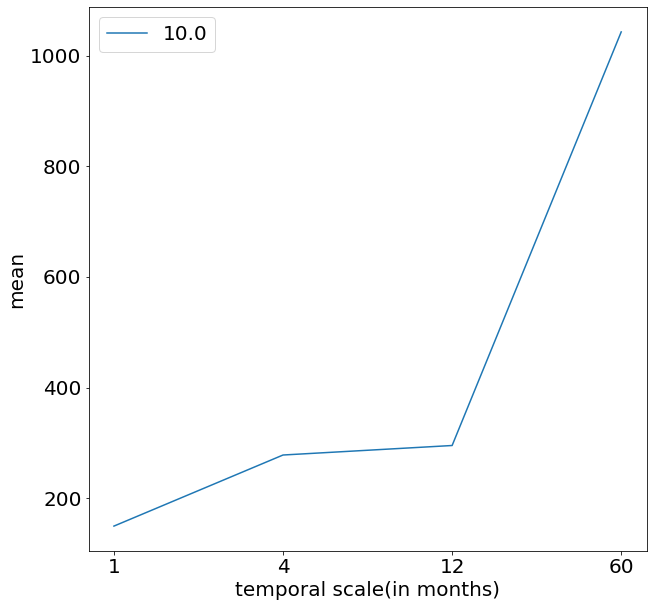

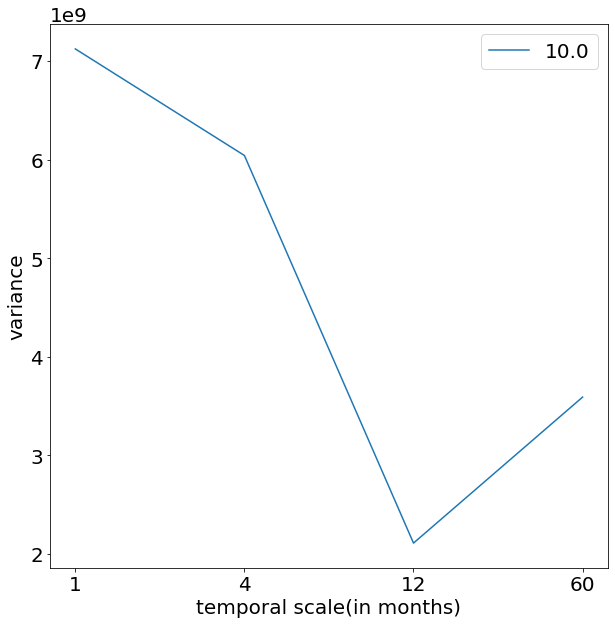

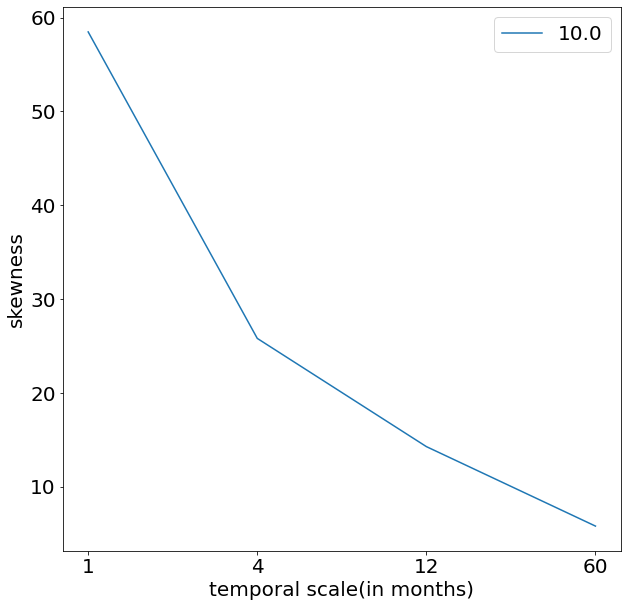

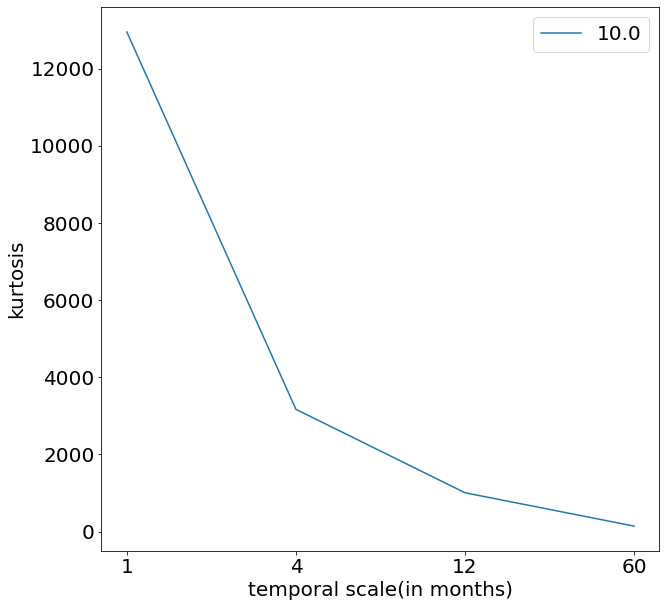

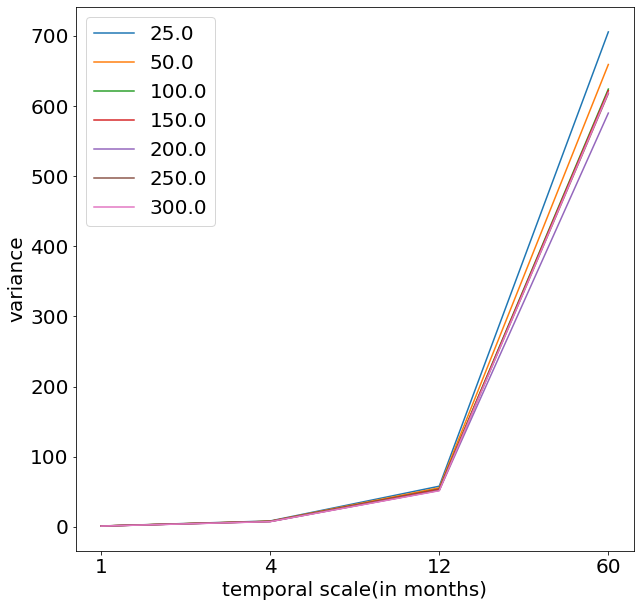

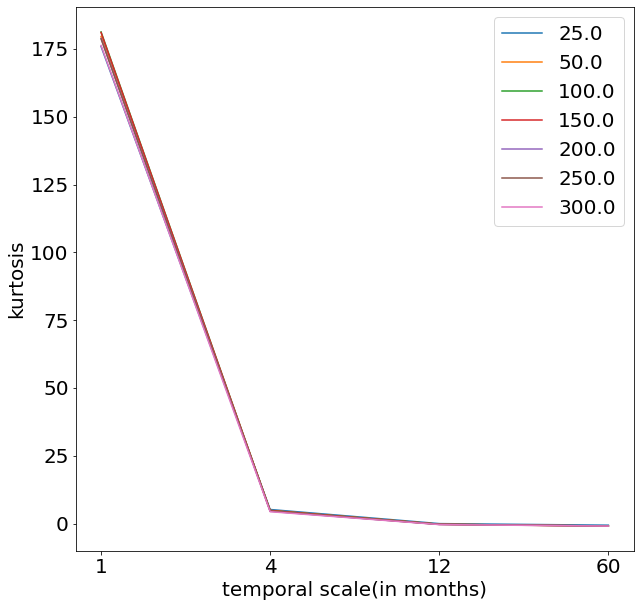

In [705]:
save_fig = True

for smallest_spatial_scale in [True, False]:
    for plot_var in ["mean", "variance", "skewness", "kurtosis"]:
        plot_distribution_analysis(all_data, spatial_scales, smallest_spatial_scale, plot_var, save=save_fig)

### Interesting points:

1. Variance for all different spatial scales(except 10.0) diverges as temporal scale increases.
2. Skewness and kurtosis values for all different spatial scales(except 10.0) converges as temporal scale increases.
3. Variance for all spatial scales except 10.0 increases with temporal scale but for 10.0 it decreases uptil temporal scale 12.0 and then increases for temporal scale 60.0

In [216]:
all_data

array([[[ 1.49547815e+02,  7.12260912e+09,  5.84780992e+01,
          1.29573829e+04],
        [ 2.78032588e+02,  6.04152079e+09,  2.58290415e+01,
          3.17074667e+03],
        [ 2.95209789e+02,  2.10929505e+09,  1.43024265e+01,
          1.00684620e+03],
        [ 1.04281936e+03,  3.59025753e+09,  5.83504540e+00,
          1.42381843e+02]],

       [[ 4.49426292e-01,  1.12789887e+00,  9.77977077e+00,
          1.75938140e+02],
        [ 1.83613228e+00,  8.29869566e+00,  8.11843235e-01,
          5.19834626e+00],
        [ 5.87429979e+00,  5.78589706e+01,  1.01494936e-01,
         -8.17868647e-03],
        [ 4.34727997e+01,  7.05685290e+02,  5.53065812e-01,
         -5.88165125e-01]],

       [[ 4.49392301e-01,  1.11806270e+00,  1.00632719e+01,
          1.79601191e+02],
        [ 1.83460196e+00,  8.00500930e+00,  8.35316759e-01,
          4.87344244e+00],
        [ 5.86670538e+00,  5.55910801e+01,  7.87579251e-02,
         -2.33316942e-01],
        [ 4.34917074e+01,  6.59220516e+

## Creating events based on gdp distribution

In [711]:
# c = 1.0
# skewness = all_data[2][0][2]
# skewness
# a = get_weighted_std(skewness, c)
# b = 1.0*2 - a
# a, b
# # all_data[2]

In [753]:
## Sigmoid function was used to restrict the weighted std value.
##  The parameter 'a' is used to stretch the sigmoid function along the x-axis so as to allow better scaling for 
## higher skewness values. The value of param 'a' is high for high skewness and it is defined as:
## a = 1-1.0/(np.log(spatial_scale))   
def get_weighted_std(skewness, std, a=1.0):
    return 1.0/(std + (np.exp(a*skewness)/(1 + np.exp(a*skewness)))-0.5)
    ## 0.5 is subtracted so that weighted_std is 1.0 when skewness is 0.0 as it should be.


def create_events(meta_gdp_data, spatial_scales, temporal_scales, all_seeds, differential=True, plot_data=True, save=True):
    if meta_gdp_data is None:
        meta_gdp_data = evaluate_distribution_metrics(spatial_scales, temporal_scales, all_seeds, differential)
        
    all_events_data = []
    all_events_percentage_data = []
    
    for l, spatial_scale in enumerate(spatial_scales):
        tmp_temporal_percentage_events = []
        for j, temporal_scale in enumerate(temporal_scales):
            tmp_percentage_events = []
            for k, seed in enumerate(all_seeds):
                df = pd.read_csv("../data/results/gdp_{}_{}.csv".format(spatial_scale, seed))
                df.rename(columns={"Unnamed: 0": "year_month"},  inplace=True)
                df_copy = df.copy(deep=True)
                df_copy = get_temporal_df(df_copy, temporal_scale)

                if differential:
                    diff_df = get_gdp_differential(df_copy)
                    diff_df = diff_df.dropna(axis=1, how="any")
                    data = diff_df.iloc[:, 1:].to_numpy().flatten()
                    
                    
                    mean = np.mean(data)
                    std = np.std(data)
                    skewness = sc.stats.skew(data)
                    a = 1.0 - 1.0/np.log(spatial_scale)
                    
                    left_std_fraction = get_weighted_std(skewness, 1.0, a)
                    right_std_fraction = 0.5 + left_std_fraction
                    
#                   right_std_fraction = 2.0 - left_std_fraction
#                     left_std_fraction = 0.2
#                     right_std_fraction = 0.5
                    
                    left_threshold = mean - left_std_fraction*std
                    right_threshold = mean + right_std_fraction*std
                    
#                     left_threshold = mean - 0.2*std
#                     right_threshold = mean + 0.3*std
                    
                    
                    diff_df.iloc[:, 1:] = pd.DataFrame(np.where((diff_df.iloc[:, 1:] <= left_threshold) | (diff_df.iloc[:, 1:] >= right_threshold), 1.0, 0.0))
                    
                    if save:
                        diff_df.to_csv("../data/results/events/gdp_{}_{}_{}_events.csv".format(spatial_scale, temporal_scale, seed), index=False)
                        
                    if plot_data:
                        filtered_events = np.sum(np.sum(diff_df.iloc[:, 1:]))
                        total_events = diff_df.iloc[:, 1:].shape[0] * diff_df.iloc[:, 1:].shape[1]
                        tmp_percentage_events.append(100.0*round(filtered_events/total_events, 2))
            
            tmp_temporal_percentage_events.append(np.mean(tmp_percentage_events))
            
        all_events_percentage_data.append(tmp_temporal_percentage_events)
        
    return all_events_percentage_data
            
                        

In [754]:
spatial_scales = [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]
temporal_scales = [1, 4, 12, 60]
all_seeds = np.arange(1, 6, 1)

In [755]:
save = True
plot_data = True

all_plot_data = create_events(all_data, spatial_scales, temporal_scales, all_seeds, plot_data=plot_data, save=save)

In [756]:
plt.bar(np.arange(0, 32, 1), np.array(all_plot_data).flatten())

<BarContainer object of 32 artists>

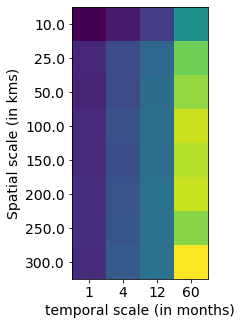

In [757]:
plt.figure(figsize=(5, 5))
plt.imshow(all_plot_data)
xticks_labels = {temporal_scale: i for i, temporal_scale in enumerate(temporal_scales)}
yticks_labels = {spatial_scale: i for i, spatial_scale in enumerate(spatial_scales)}
plt.xticks(np.arange(len(xticks_labels)), labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)), labels=yticks_labels)
plt.xlabel("temporal scale (in months)")
plt.ylabel("Spatial scale (in kms)")
plt.savefig("../data/pictures/percentage_events.png", bbox_inches='tight')

# Transfer Entropy

## Calculating marginal, joint and conditional distributions

1. Find p(x_t+1|x_t)
2. Find p(x_t, y_t) -> p(y_t | x_t) * p(x_t)
3. Find p(x_t+1| x_t, y_t)

In [758]:
def get_marginal_probabilty(data):
    probs = {}
    total_events = len(data)
    probs[1] = np.sum(data)/total_events
    probs[0] = 1 - probs[1]
    return probs

def get_conditional_probability_xt1_xt(x):
    probs = {"0|0": 0, "0|1": 0, "1|0": 0, "1|1": 0}
    total_events = len(x)-1
    count_xt_0, count_xt_1 = 0, 0
    
    for i in range(len(x)-1):
        xt, xt1 = x[i], x[i+1]
        probs["{}|{}".format(xt1, xt)] += 1
        if xt == 0:
            count_xt_0 += 1
        else:
            count_xt_1 += 1
        
    for key, val in probs.items():
        if val > 0:
            if key in ["0|0", "1|0"]:
                probs[key] = val/count_xt_0
            else:
                probs[key] = val/count_xt_1
        
    return probs

def get_conditional_probability_xt_yt(x, y):
    assert len(x) == len(y), "column lengths different."
    probs = {"0|0": 0, "0|1": 0, "1|0": 0, "1|1": 0}
    total_events = len(x)
    
    count_xt_1 = np.sum(x)
    count_xt_0 = len(x) - count_xt_1
    
    
    for xt, yt in zip(x, y):
        probs["{}|{}".format(yt, xt)] += 1
    
    for key, val in probs.items():
        if val > 0:
            if key in ["0|0", "1|0"]:
                probs[key] = val/count_xt_0
            else:
                probs[key] = val/count_xt_1
        
    return probs

def get_conditional_probability_xt1_xt_yt(x, y):
    assert len(x) == len(y), "column lengths different."
    probs = {
        "0|0,0": 0, "0|0,1": 0, "0|1,0": 0, "0|1,1": 0,
        "1|0,0": 0, "1|0,1": 0, "1|1,0": 0, "1|1,1": 0
    }
    total_events = len(x)-1
    count_0_0, count_0_1, count_1_0, count_1_1 = 0, 0, 0, 0
    
    for i in range(len(x)-1):
        xt, xt1, yt = x[i], x[i+1], y[i]
        probs["{}|{},{}".format(xt1, xt, yt)] += 1
        if xt == 0 and yt == 0:
            count_0_0 += 1
        elif xt == 0 and yt == 1:
            count_0_1 += 1
        elif xt == 1 and yt == 0:
            count_1_0 += 1
        else:
            count_1_1 += 1
        
    for key, val in probs.items():
        if val > 0:
            if key.split("|")[-1] == "0,0":
                probs[key] = val/count_0_0
            elif key.split("|")[-1] == "0,1":
                probs[key] = val/count_0_1
            elif key.split("|")[-1] == "1,0":
                probs[key] = val/count_1_0
            else:
                probs[key] = val/count_1_1
        
    return probs

def get_joint_probability_xt_yt(cond_prob_xt_yt, marginal_prob_xt):
    probs = {"0,0": 0, "0,1": 0, "1,0": 0, "1,1": 0}
    for i in [0, 1]:# corresponds to x
        for j in [0, 1]: # corresponds to y
            probs["{},{}".format(j, i)] = cond_prob_xt_yt["{}|{}".format(j, i)] * marginal_prob_xt[i]
            
    return probs

def get_joint_probability_xt1_xt_yt(cond_prob_xt1_xt_yt, joint_prob_xt_yt):
    probs = {
        "0,0,0": 0, "0,0,1": 0, "0,1,0": 0, "0,1,1": 0,
        "1,0,0": 0, "1,0,1": 0, "1,1,0": 0, "1,1,1": 0
    }
    
    for i in [0,1]: # corresponds to xt1
        for j in [0,1]: # corresponds to xt
            for k in [0,1]: #corresponds to yt
                probs["{},{},{}".format(i,j,k)] = cond_prob_xt1_xt_yt["{}|{},{}".format(i,j,k)]*joint_prob_xt_yt[
                    "{},{}".format(j,k)]
    return probs
    

def get_transfer_entropy(x, y):
    ## x and y are time-series data of any two voronoi tessellations
    
    # get probabilites
    x, y = list(x.astype(np.int32)), list(y.astype(np.int32))
    marginal_xt = get_marginal_probabilty(x)
    marginal_yt = get_marginal_probabilty(y)
    
    cond_xt1_xt = get_conditional_probability_xt1_xt(x)
    cond_xt1_xt_yt = get_conditional_probability_xt1_xt_yt(x, y)
    
    cond_xt_yt = get_conditional_probability_xt_yt(x, y)
    
    joint_xt_yt = get_joint_probability_xt_yt(cond_xt_yt, marginal_xt)
    joint_xt1_xt_yt = get_joint_probability_xt1_xt_yt(cond_xt1_xt_yt, joint_xt_yt)
    
    # evaluate transfer entropy
    transfer_entropy = 0.0
    for i in [0,1]:
        for j in [0,1]:
            for k in [0,1]:
                tmp_joint_xt1_xt_yt = joint_xt1_xt_yt["{},{},{}".format(i,j,k)]
                tmp_cond_xt1_xt_yt = cond_xt1_xt_yt["{}|{},{}".format(i,j,k)]
                tmp_cond_xt1_xt = cond_xt1_xt["{}|{}".format(i,j)]
                
                if tmp_joint_xt1_xt_yt != 0:
                    transfer_entropy += tmp_joint_xt1_xt_yt * np.log2(tmp_cond_xt1_xt_yt/tmp_cond_xt1_xt)
    
    return transfer_entropy

    # evaluate mutual information
#     mutual_info = 0.0
#     for i in [0,1]:
#         for j in [0,1]:
#                 tmp_joint_xt_yt = joint_xt_yt["{},{}".format(i,j)]
#                 tmp_marginal_xt = marginal_xt[i]
#                 tmp_marginal_yt = marginal_yt[j]
                
#                 if tmp_joint_xt_yt != 0:
#                     mutual_info += tmp_joint_xt_yt * np.log(tmp_joint_xt_yt/(tmp_marginal_xt*tmp_marginal_yt))

#     return mutual_info
              
    
def get_entropy(x):
    marginal_xt = get_marginal_probabilty(x)
    entropy = -(marginal_xt[0]*np.log2(1.0 if marginal_xt[0] == 0.0 else marginal_xt[0]) + marginal_xt[1]*np.log2(1.0 if marginal_xt[1] == 0.0 else marginal_xt[1]))
    return entropy
    
def lambda_entropy(df_column, df):
    return df.iloc[:, 1:].corrwith(df_column, method=get_transfer_entropy)
    
def tmp_func2(column2, column1):
    return get_transfer_entropy(column1, column2)
    
    
def tmp_func1(column_data, array):
    pairwise_entropy_for_one_col = np.apply_along_axis(tmp_func2, 0, array, column_data)
    return pairwise_entropy_for_one_col
    
    
def get_transfer_entropy_df(df):
    df_array = np.array(df.iloc[:, 1:])
    pairwise_entropy = np.apply_along_axis(tmp_func1, 0, df_array, df_array)
    
    
#     pairwise_entropy = df.iloc[:, 1:].swifter.apply(lambda_entropy, axis=0, args=(df, ))
#     pairwise_entropy = []
#     for i in range(1, len(df.columns)):
#         pairwise_entropy.append(df.iloc[:, 1:].corrwith(df.iloc[:, i], method=get_transfer_entropy))
    
    new_df = pd.DataFrame(np.array(pairwise_entropy)).transpose()
    new_df.columns=df.columns[1:]
    new_df.set_index(df.columns[1:], inplace=True)
        
    return new_df

In [759]:
# def change_col_names_transfer_entropy_df():
#     for file in glob("../data/results/transfer_entropy/*"):
#         tmp = file.split("/")[-1].split("_")
#         spatial_scale = tmp[2]
#         seed = tmp[-1].split(".")[0]
#         tf_df = pd.read_csv(file)
# #         tf_df.drop("Unnamed: 0", axis=1, inplace=True)
#         events_df = pd.read_csv("../data/results/events/gdp_{}_4_{}_events.csv".format(spatial_scale, seed))

#         tf_df.columns=events_df.columns[1:]
#         tf_df.set_index(events_df.columns[1:], inplace=True)
#         tf_df.to_csv(file, index=False)

In [760]:
# change_col_names_transfer_entropy_df()

In [761]:
# df = pd.read_csv("../data/results/events/gdp_50.0_1_1_events.csv")

# # entropies = []
# # for i in range(1, len(df.columns)):
# #     entropies.append(get_entropy(df.iloc[:, i]))

# get_transfer_entropy(df.iloc[:, 1], df.iloc[:, 3])

In [762]:
# df = pd.read_csv("../data/results/events/gdp_150.0_4_1_events.csv")
# get_transfer_entropy_df(df)
# # tmp_df.columns=df.columns[1:]
# # tmp_df.set_index(df.columns[1:])

In [763]:
# tp_df = get_transfer_entropy_df(df)
# tp_df
# df.columns[1:]

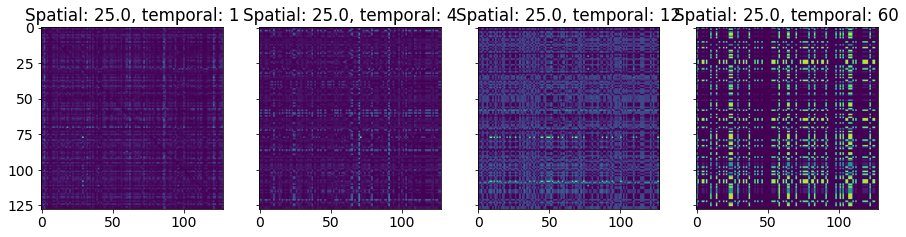

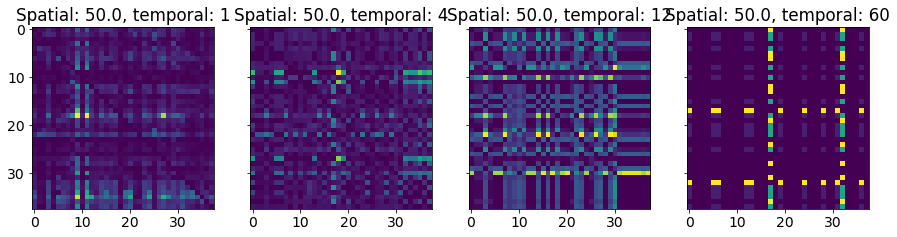

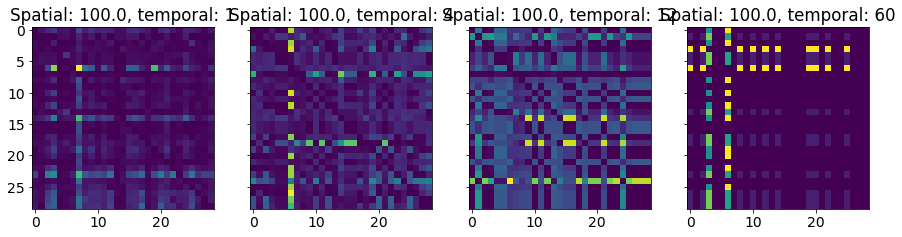

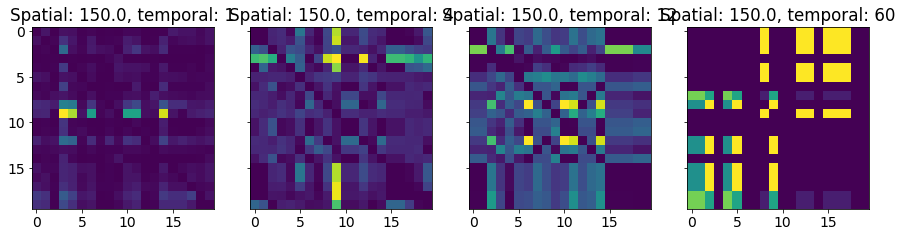

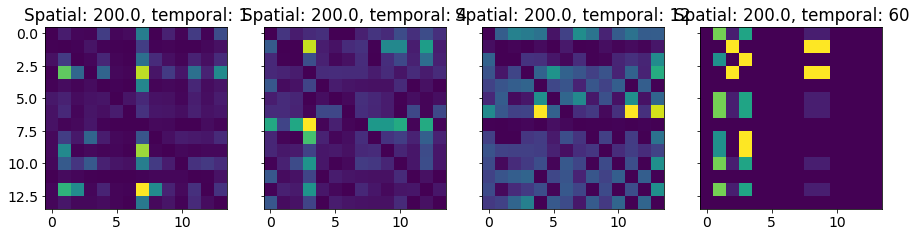

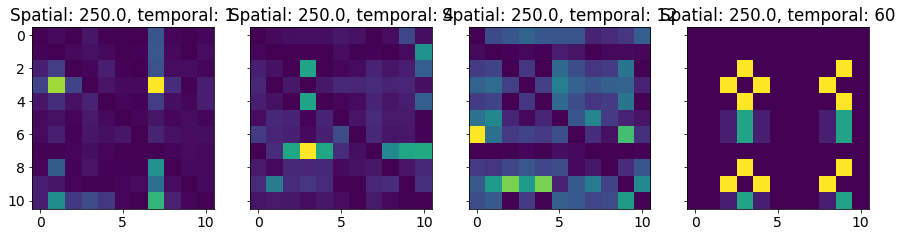

In [764]:
for spatial_scale in spatial_scales:
    fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    for i, temporal_scale in enumerate(temporal_scales):
        for seed in np.arange(1, 6, 1):
            df = pd.read_csv("../data/results/events/gdp_{}_{}_{}_events.csv".format(spatial_scale, temporal_scale, seed))
            transfer_entropy = get_transfer_entropy_df(df)
            axes[i].imshow(transfer_entropy)
            axes[i].set_title("Spatial: {}, temporal: {}".format(spatial_scale, temporal_scale))
            transfer_entropy.to_csv("../data/results/transfer_entropy/transfer_entropy_{}_{}_{}.csv".format(spatial_scale, temporal_scale, seed), index=False)

Negative transfer entropy means misinformative entropy. Meaning? Check transfer_entropy book
One reason found in the book:
"indicating misinformation, perhaps as ineffectual
influence, where the target agents respond in a different way to the source agents
than would usually be predicted. The latter may occur where multiple sources are influencing a target agent in different ways, and the behaviour of the target is not
predictable from a single source in isolation."

ToDo: 
1. Instead of voronoi tessellation number in the pairwise transfer entropy matrix, use the distance between two cells as the column names so as to see how negative transfer entropy changes with distance

## Evaluating pairwise site distance

In [765]:
from geopy import distance

In [766]:
def get_sites_location(spatial_scale, seed):
    with open("../data/sims/2021_11_radius-{}_seed-{}.pkl".format(spatial_scale, seed), "rb") as f:
        sim_data = pickle.load(f)
    return sim_data["site_location"]

def get_pairwise_distance_between_sites(sites_location, lons, lats):
    all_dist = {}
    for key_i, site_i in sites_location.items():
        site_i = tuple([int(site_i[0]), int(site_i[1])])
        site_i_lat, site_i_lon = lats[site_i], lons[site_i]
#         tmp_dist = []
        for key_j, site_j in sites_location.items():
            site_j = tuple([int(site_j[0]), int(site_j[1])])
            site_j_lat, site_j_lon = lats[site_j], lons[site_j]
            dist = distance.distance((site_i_lat, site_i_lon), (site_j_lat, site_j_lon)).km
#             tmp_dist.append()
            all_dist[(key_i, key_j)] = dist
    return all_dist

## Plotting transfer entropy and distance relationship

In [767]:
from sklearn.cluster import KMeans, SpectralClustering, MeanShift

In [768]:
lons, lats = np.load("../data/lons.npy"), np.load("../data/lats.npy")

In [769]:
# with open("../data/sims/2021_11_radius-{}_seed-{}.pkl".format(100.0, 1), "rb") as f:
#     sim_data = pickle.load(f)

In [770]:
# with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(100.0, 1), "rb") as f:
#     tess_data = pickle.load(f)
    
# chosen_sites = {}
# for key in tess_data["site_to_point_dict"].keys():
#     chosen_sites[key] = (tess_data["sites"][key][1], tess_data["sites"][key][0])

In [771]:
def calculate_centroid_sites(tess_data):
    centroid_sites = {}
    for key, item in tess_data["site_to_point_dict"].items():
        numerator_x = 0.0
        numerator_y = 0.0
        for point in item:
            numerator_x += point[1]
            numerator_y += point[0]

        centroid_x = np.floor(numerator_x/len(item))
        centroid_y = np.floor(numerator_y/len(item))

        centroid_sites[key] = [centroid_y, centroid_x]

    return centroid_sites


def relocate_sites_to_centroid(sites, tess_data):
    centroid_sites = calculate_centroid_sites(tess_data)

    keys_to_del = []
    for key, site in sites.items():
        if key not in centroid_sites:
            keys_to_del.append(key)
        else:
            sites[key] = centroid_sites[key]
            
    for key in keys_to_del:
        del sites[key]
    return sites

In [734]:
def plot_correlation_vs_distance(spatial_scales, temporal_scales, seed, events_data=False):
    for spatial_scale in spatial_scales:
        fig, axes = plt.subplots(1, len(temporal_scales), figsize=(15, 5), sharey=True)
        sites_location = get_sites_location(spatial_scale, seed)
        pairwise_dist = None
        
        if not events_data:
            df = pd.read_csv("../data/results/gdp_{}_{}.csv".format(spatial_scale, seed))

        for i, temporal_scale in enumerate(temporal_scales):
            if events_data:
                diff_df = pd.read_csv("../data/results/events/gdp_{}_{}_{}_events.csv".format(
                    spatial_scale, temporal_scale, seed))
            
            else:
                df_copy = df.copy(deep=True)
                temporal_df = get_temporal_df(df_copy, temporal_scale)
                diff_df = get_gdp_differential(temporal_df).iloc[:, 1:]
            
            if events_data:
                corr_method = "spearman"
            else:
                corr_method = "pearson"
            corr_df = diff_df.iloc[:, 1:].corr(method=corr_method).dropna(how='all',axis=1).dropna(how="all", axis=0)
            
            
            if pairwise_dist is None:
                ## sites were stored as (x,y)
                chosen_sites = {int(i): (sites_location[int(i)][1], sites_location[int(i)][0]) for i in corr_df.columns}
                
                with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(spatial_scale, seed), "rb") as f:
                    tess_data = pickle.load(f)
                sites_centroid = relocate_sites_to_centroid(chosen_sites, tess_data)
                pairwise_dist = get_pairwise_distance_between_sites(sites_centroid, lons, lats)

#             selected_cols = sorted(list(sites_centroid.keys()))
            selected_cols = sorted(list(corr_df.columns))
            distances, corrs = [], []
                
#             print(corr_df.columns)
#             print()
#             print(corr_df.index)
#             print()
#             print(selected_cols)
#             print("_"*10)

            
            for j, col1 in enumerate(selected_cols):
                for _, col2 in enumerate(selected_cols[j+1:]):
                    if int(col1) not in chosen_sites or int(col2) not in chosen_sites:
                        continue
                        
                    tmp_distance = pairwise_dist[(int(col1), int(col2))]
                    corr = corr_df[str(col1)][str(col2)]
                    corrs.append(corr)
                    distances.append(tmp_distance)
                                        
            axes[i].scatter(distances, corrs)
            axes[i].set_xlabel("Distance(in kms)")
            axes[i].set_ylabel("correlation")
            axes[i].set_ylim((-1.0, 1.0))
            axes[i].set_title("Spatial: {}, temporal: {}".format(spatial_scale, temporal_scale))
            
        if events_data:
            save_filename = "../data/pictures/corr_vs_distance_spatial_events_{}_seed_{}.png".format(spatial_scale, seed)
        else:
            save_filename = "../data/pictures/corr_vs_distance_spatial_{}_seed_{}.png".format(spatial_scale, seed)
            
        plt.savefig(save_filename, bbox_inches='tight')

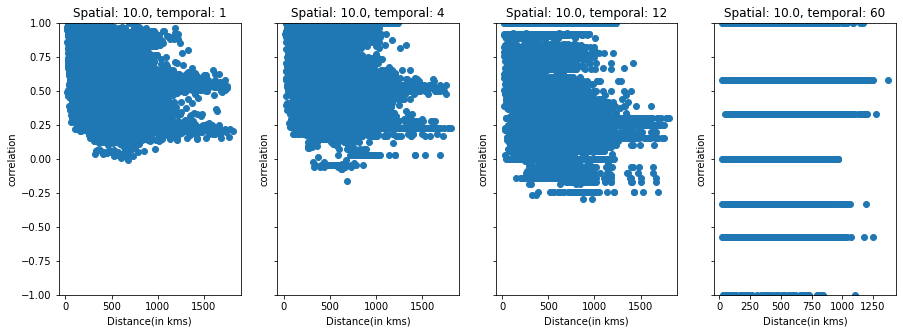

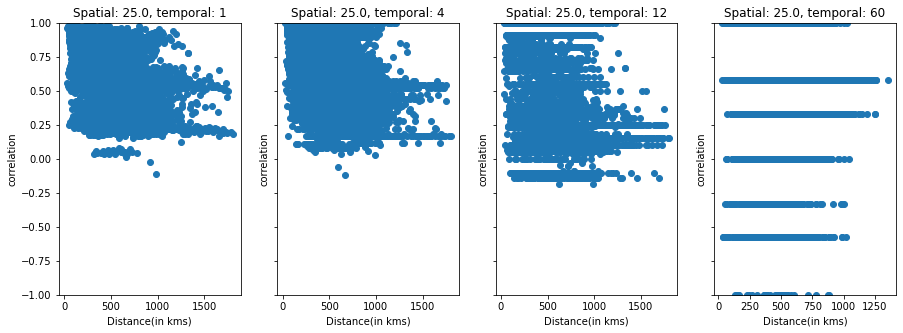

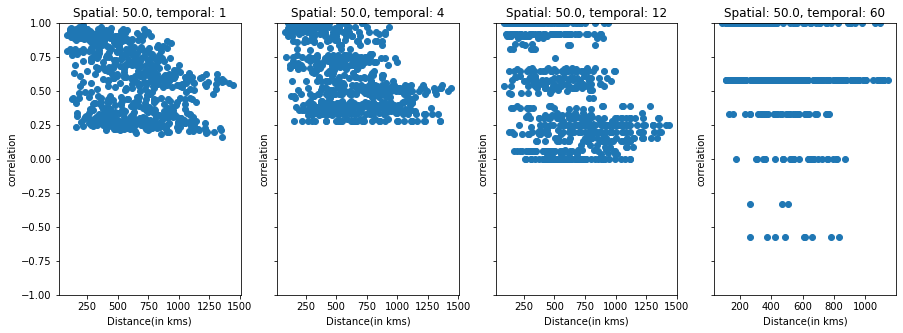

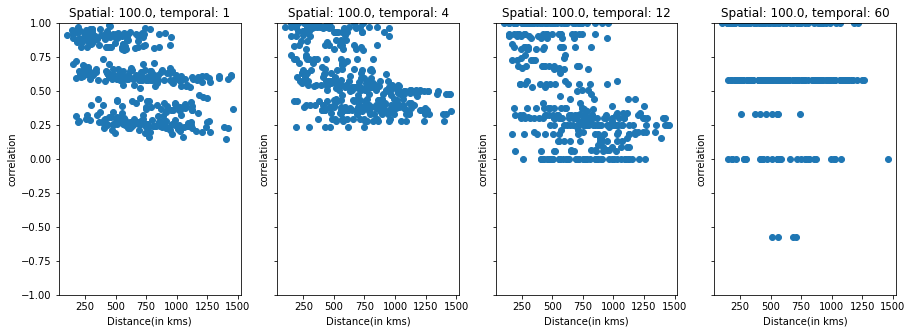

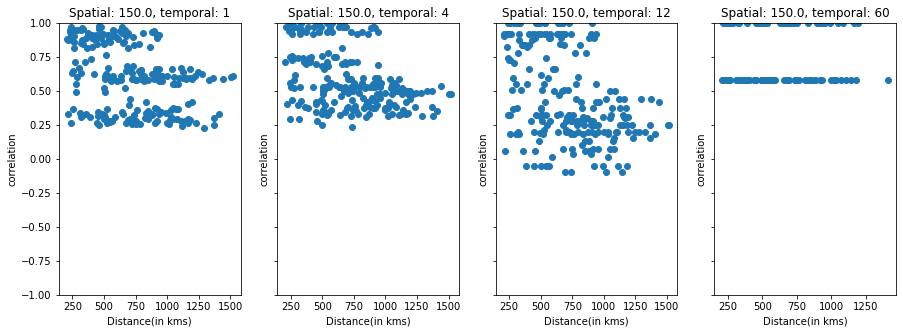

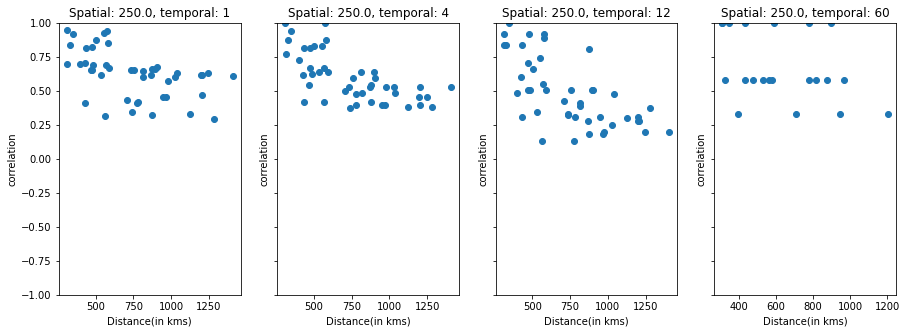

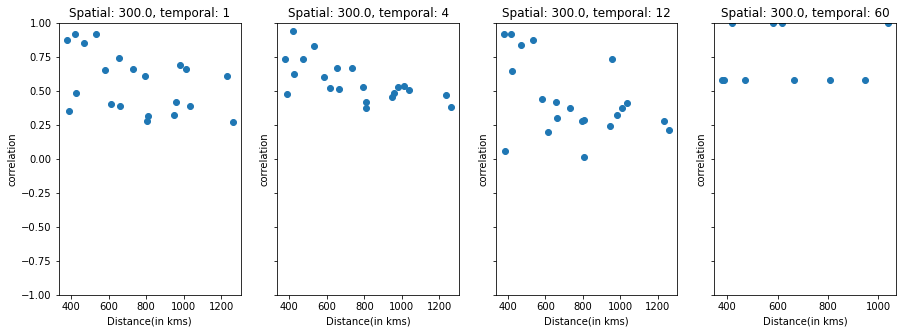

In [94]:
# spatial_scales = [10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]
# temporal_scales = [1, 4, 12, 60]
# seed = 2
# events_data = True
# plot_correlation_vs_distance(spatial_scales, temporal_scales, seed, events_data=events_data)

In [772]:
def plot_transfer_entropy_vs_distance(spatial_scales, temporal_scales, seed, n_clusters=10):
    cmap = plt.cm.get_cmap("Pastel1", n_clusters)
    for spatial_scale in spatial_scales:
        fig, axes = plt.subplots(1, len(temporal_scales), figsize=(15, 5), sharey=True)
        sites_location = get_sites_location(spatial_scale, seed)
        pairwise_dist = None

        for i, temporal_scale in enumerate(temporal_scales):
            transfer_entropy = pd.read_csv("../data/results/transfer_entropy/transfer_entropy_{}_{}_{}.csv".format(spatial_scale, temporal_scale, seed))
            transfer_entropy.set_index(transfer_entropy.columns, inplace=True)
            if pairwise_dist is None:
                ## sites were stored as (x,y)
                chosen_sites = {int(i): (sites_location[int(i)][1], sites_location[int(i)][0]) for i in transfer_entropy.columns}
                
                with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(spatial_scale, seed), "rb") as f:
                    tess_data = pickle.load(f)
                sites_centroid = relocate_sites_to_centroid(chosen_sites, tess_data)
                pairwise_dist = get_pairwise_distance_between_sites(sites_centroid, lons, lats)
                
            events_df = pd.read_csv("../data/results/events/gdp_{}_{}_{}_events.csv".format(spatial_scale, temporal_scale, seed))

            abs_entropies = {}
            for m, col_name in enumerate(events_df.columns[1:]):
                abs_entropies[col_name] = get_entropy(events_df.iloc[:, m+1])
                

            data_dict = transfer_entropy.to_dict()
            selected_cols = sorted(list(sites_centroid.keys()))
            distances, entropies = [], []
            clustering_data = []
            
            for j, col1 in enumerate(selected_cols):
                for _, col2 in enumerate(selected_cols[j+1:]):
                    tmp_distance = pairwise_dist[(int(col1), int(col2))]
#                     max_entropy = max(data_dict[str(col1)][int(col2)], data_dict[str(col2)][int(col1)])
#                     entropies.append(max_entropy)
                    
                    max_perc_entropy = max(100.0*data_dict[str(col1)][str(col2)]/(1.0 if abs_entropies[str(col1)] == 0 else abs_entropies[str(col1)]), 
                                           100.0*data_dict[str(col2)][str(col1)]/(1.0 if abs_entropies[str(col2)] == 0 else abs_entropies[str(col2)]))
                    
                    entropies.append(max_perc_entropy)

                    distances.append(tmp_distance)
                    
                    
#                     clustering_data.append([100.0*tmp_distance/1600.0, max_perc_entropy]) #dividing by 1600(max distance) to normalize the x axis for clustering.
                    
#             clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(clustering_data)
#             clustering = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', 
#                                             random_state=0).fit(clustering_data)
#             clustering = MeanShift(bandwidth=2).fit(clustering_data)

#             colors = [cmap(l) for l in clustering.labels_]
                
#             print(distances)
#             print()
#             print(entropies)
                    
            axes[i].scatter(distances, entropies)
#             if spatial_scale == 10.0:
#                 axes[i].scatter(distances, entropies)
#             else:
#                 sns.kdeplot(entropies, ax=axes[i], linestyle="--")
            axes[i].set_xlabel("Distance(in kms)")
            axes[i].set_ylabel("transfer entropy(%)")
            axes[i].set_ylim((0.0, 100.0))
            axes[i].set_title("Spatial: {}, temporal: {}".format(spatial_scale, temporal_scale))

        plt.savefig("../data/pictures/transfer_entropy_vs_distance_spatial_{}_seed_{}.png".format(spatial_scale, seed), bbox_inches='tight')

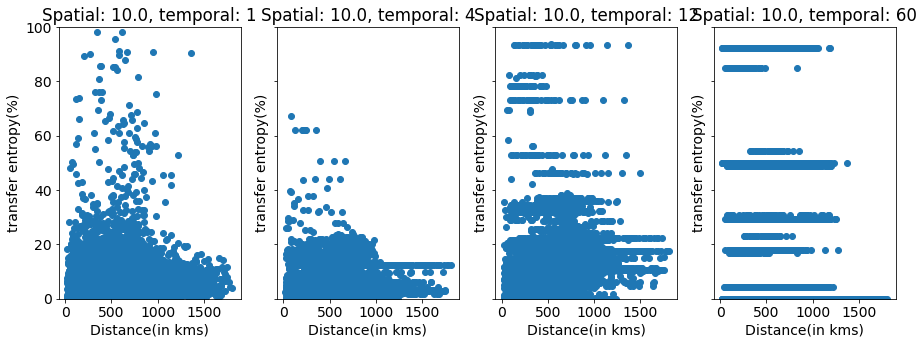

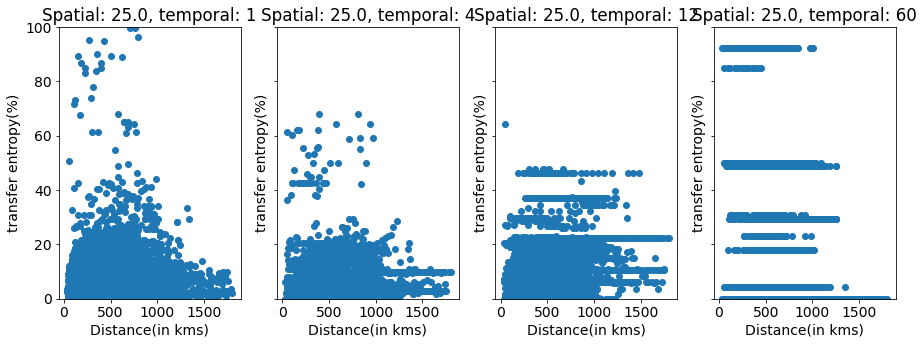

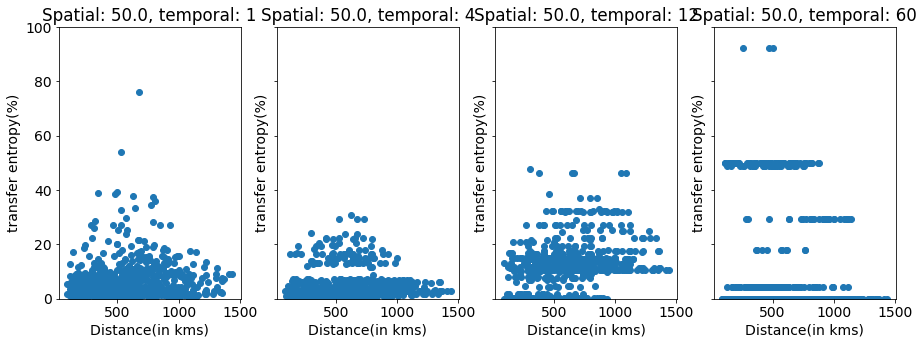

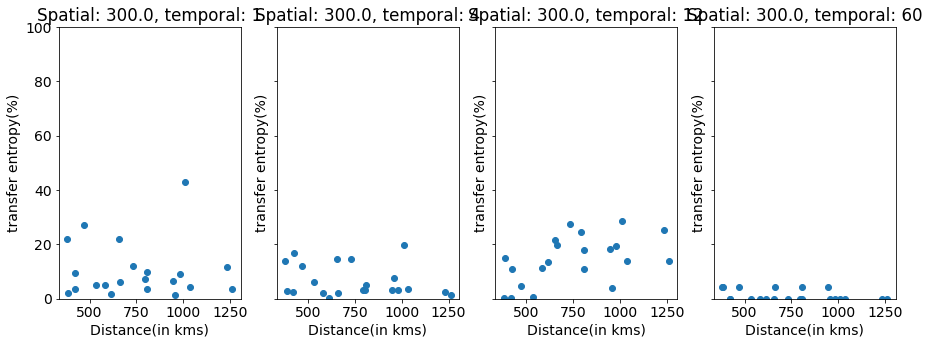

In [773]:
seed = 2
n_clusters=5
plot_transfer_entropy_vs_distance(spatial_scales, temporal_scales, seed, n_clusters=n_clusters)

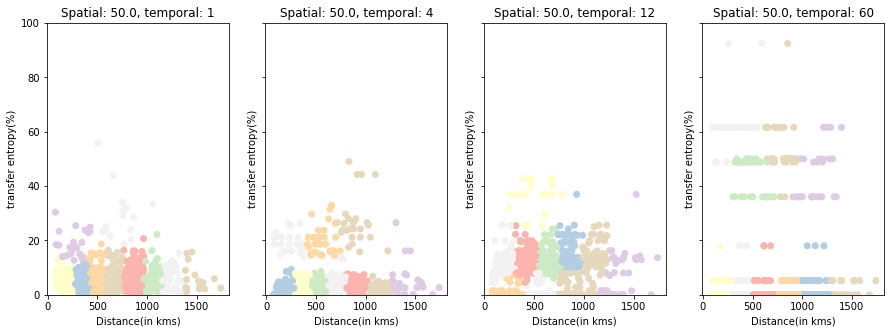

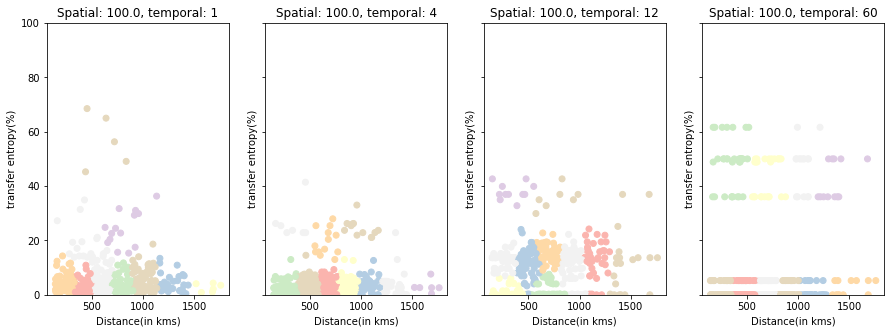

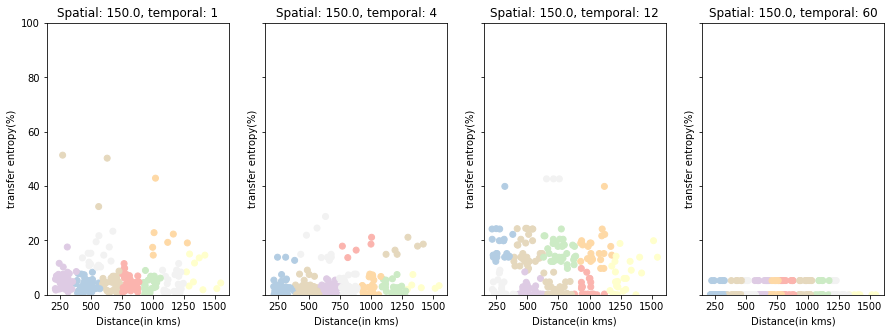

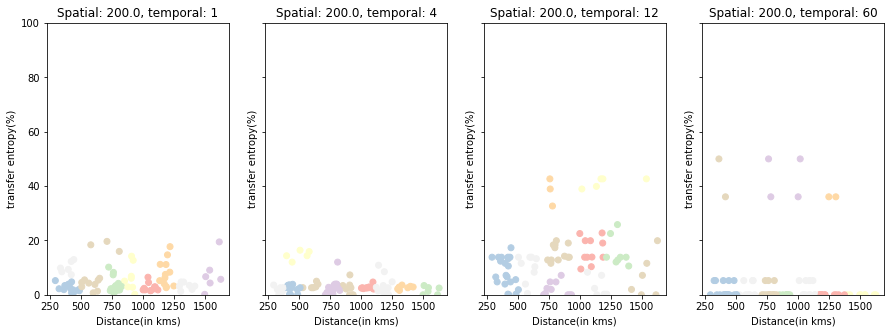

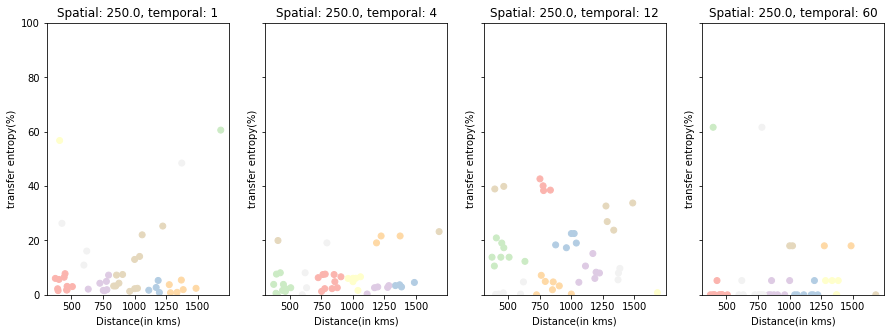

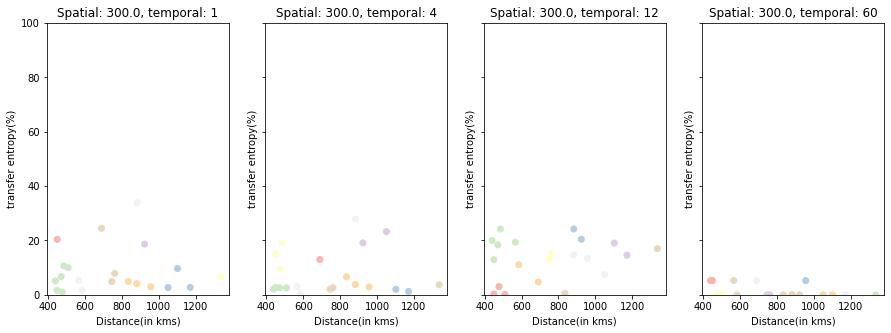

In [1038]:
# seed = 2
# n_clusters=5
# plot_transfer_entropy_vs_distance(spatial_scales, temporal_scales, seed, n_clusters=n_clusters)

ToDo:
1. Change std in events creation and see if it changes anything -- Done. Not much changed
2. There seems to be some kind of clusters in the distribution above. Use some clustering methods to find such clusters in the distance vs entropies data -- DONE. not too interesting clusters
3. Check out some other entropy based methods for time-series -- DONE. This one is the most common method
4. compare transfer entropy to the entropy of the variable. So, this time plot TE(x->y) and TE(y->x) both not just one. Plot a percentage graph. -- DONE

## Create graphs based on transfer entropy(%)

In [1056]:
def get_mean_degree(G):
    return np.mean(np.array(list(G.degree(G.nodes)))[:, 1])

def get_transfer_entropy_graph_analysis(spatial_scales, temporal_scales, seeds, threshold=0.0, evaluate_degree=False):
    all_closeness1, all_clustering1, all_closeness2, all_clustering2 = {}, {}, {}, {}
    for spatial_scale in tqdm(spatial_scales):
#         fig, axes = plt.subplots(1, len(temporal_scales), figsize=(15, 5), sharey=False)
        for t, temporal_scale in enumerate(temporal_scales):
            for seed in seeds:
                transfer_entropy_df = pd.read_csv("../data/results/transfer_entropy/transfer_entropy_{}_{}_{}.csv".format(
                spatial_scale, temporal_scale, seed))
                transfer_entropy_array = np.array(transfer_entropy_df)
            
                events_df = pd.read_csv("../data/results/events/gdp_{}_{}_{}_events.csv".format(
                    spatial_scale, temporal_scale, seed))

                abs_entropies = []
                for m in range(1, len(events_df.columns)):
                    abs_entropies.append(get_entropy(events_df.iloc[:, m]))
                    
                G1 = nx.Graph()
                nodes = np.arange(len(transfer_entropy_array))
                G1.add_nodes_from(nodes)
                
                G2 = nx.Graph()
                nodes = np.arange(len(transfer_entropy_array))
                G2.add_nodes_from(nodes)
                
                G3 = nx.Graph()
                nodes = np.arange(len(transfer_entropy_array))
                G3.add_nodes_from(nodes)
                
                G4 = nx.Graph()
                nodes = np.arange(len(transfer_entropy_array))
                G4.add_nodes_from(nodes)
                

                edges1, edges2, edges3, edges4 = [], [], [], []
                for i in range(0, len(nodes)):
                    for j in range(i+1, len(nodes)):
                        transfer_entropy1 = transfer_entropy_array[j, i]
                        
                        if transfer_entropy1 == 0.0:
                            weight_i_j_1 = 10**3 ##giving a high value
                            weight_i_j_2 = 10**(-3)
                        else:
                            weight_i_j_1 = abs_entropies[j]/(transfer_entropy1)
                            weight_i_j_2 = transfer_entropy1/abs_entropies[j]
                        
                        if weight_i_j_2 >= threshold:
                            edges1.append((nodes[i], nodes[j], weight_i_j_1))
                            edges2.append((nodes[i], nodes[j], weight_i_j_2))
                            
                        
                        transfer_entropy2 = transfer_entropy_array[i, j]
                        abs_entropy2 = abs_entropies[i]
                        
                        if transfer_entropy2 == 0.0:
                            weight_j_i_1 = 10**3 ##giving a high value
                            weight_j_i_2 = 10**(-3)
                        else:
                            weight_j_i_1 = abs_entropies[i]/(transfer_entropy2)
                            weight_j_i_2 = transfer_entropy2/abs_entropies[i]
                            
                        if weight_j_i_2 >= threshold:
                            edges3.append((nodes[j], nodes[i], weight_j_i_1))
                            edges4.append((nodes[j], nodes[i], weight_j_i_2))
                        
                G1.add_weighted_edges_from(edges1, weight="inverse transfer entropy")
                G2.add_weighted_edges_from(edges2, weight="transfer entropy")
                
                G3.add_weighted_edges_from(edges3, weight="inverse transfer entropy")
                G4.add_weighted_edges_from(edges4, weight="transfer entropy")
                
                if evaluate_degree:
                    closeness_mean1 = get_mean_degree(G1)
                    clustering_mean1 = get_mean_degree(G2)
                    closeness_mean2 = get_mean_degree(G3)
                    clustering_mean2 = get_mean_degree(G4)
                else:
                    closeness1 = nx.closeness_centrality(G1, distance='inverse transfer entropy')
#                     print(len(edges1), len(closeness1))
                    clustering1 = nx.clustering(G2, weight='transfer entropy')
#                     print(len(edges2), len(clustering1))

                    closeness2 = nx.closeness_centrality(G3, distance='inverse transfer entropy')
#                     print(len(edges3), len(closeness2))
                    clustering2 = nx.clustering(G4, weight='transfer entropy')
#                     print(len(edges4), len(clustering2))
                    
#                     print("_"*10)

    #                 if abs(np.std(list(closeness1.values())) - 0.0) < 10**(-5):
    #                     sns.kdeplot([list(closeness1.values())[0]]*len(closeness1))
    #                 else:
    #                     sns.kdeplot(closeness1.values(), ax=axes[t])

    #                 if abs(np.std(list(closeness2.values())) - 0.0) < 10**(-5):
    #                     sns.kdeplot([list(closeness2.values())[0]]*len(closeness2))
    #                 else:
    #                     sns.kdeplot(closeness2.values(), ax=axes[t])

    #                 axes[t].set_title("Spatial: {}, temporal: {}".format(spatial_scale, temporal_scale))
    #                 axes[t].set_xlabel("closeness")

                    closeness_mean1 = np.mean(list(closeness1.values()))
                    clustering_mean1 = np.mean(list(clustering1.values()))
                    closeness_mean2 = np.mean(list(closeness2.values()))
                    clustering_mean2 = np.mean(list(clustering2.values()))
                    
                all_closeness1[(spatial_scale, temporal_scale, seed)] = closeness_mean1
                all_clustering1[(spatial_scale, temporal_scale, seed)] = clustering_mean1
                all_closeness2[(spatial_scale, temporal_scale, seed)] = closeness_mean2
                all_clustering2[(spatial_scale, temporal_scale, seed)] = clustering_mean2


    all_closeness_mean, all_clustering_mean = {}, {}
    for spatial_scale in spatial_scales:
        for temporal_scale in temporal_scales:
            tmp1, tmp2 = [], []
            for seed in seeds:
                tmp1.append(all_closeness1[(spatial_scale, temporal_scale, seed)])
                tmp1.append(all_closeness2[(spatial_scale, temporal_scale, seed)])
                
                tmp2.append(all_clustering1[(spatial_scale, temporal_scale, seed)])
                tmp2.append(all_clustering2[(spatial_scale, temporal_scale, seed)])
                
            all_closeness_mean[(spatial_scale, temporal_scale)] = (np.mean(tmp1), sc.stats.sem(tmp1))
            all_clustering_mean[(spatial_scale, temporal_scale)] = (np.mean(tmp2), sc.stats.sem(tmp2))
    
    return all_closeness_mean, all_clustering_mean


def create_graph_analysis_entropy_df(data, data_type="closeness", threshold=threshold):
    df_data, df_data2 = [], []
    for radius in all_radius:
        tmp, tmp2 = [], []
        for temporal in all_temporal:
            tmp.append(round(data[(radius, temporal)][0], 2))
            tmp2.append(round(data[(radius, temporal)][1], 2))
        df_data.append(tmp)
        df_data2.append(tmp2)

    df = pd.DataFrame(df_data, columns=[all_temporal])
    df2 = pd.DataFrame(df_data2, columns=[all_temporal])
    df.index = all_radius
    df2.index = all_radius
    df.to_csv("../data/entropy_based_{}_threshold-{}_events_data.csv".format(data_type, threshold))
    df2.to_csv("../data/entropy_based_{}_threshold-{}_events_data_std.csv".format(data_type, threshold))
    return df


def plot_entropy_graph_analysis(evaluate_degree=False):
    all_closeness_data_mean, all_closeness_data_std = {}, {}
    all_clustering_data, all_clustering_data_std = {}, {}
    
    if evaluate_degree:
        tmp = "_degree"
    else:
        tmp = ""

    for threshold in thresholds:
        df1 = pd.read_csv("../data/entropy_based_closeness{}_threshold-{}_events_data.csv".format(tmp, threshold))
        df2 = pd.read_csv("../data/entropy_based_clustering{}_threshold-{}_events_data.csv".format(tmp, threshold))
        df3 = pd.read_csv("../data/entropy_based_closeness{}_threshold-{}_events_data_std.csv".format(tmp, threshold))
        df4 = pd.read_csv("../data/entropy_based_clustering{}_threshold-{}_events_data_std.csv".format(tmp, threshold))

        for temporal_scale in all_temporal:
            spatial_data1 = list(df1[str(temporal_scale)])
            spatial_data2 = list(df2[str(temporal_scale)])
            spatial_data3 = list(df3[str(temporal_scale)])
            spatial_data4 = list(df4[str(temporal_scale)])

            all_closeness_data_mean[(temporal_scale, threshold)] = spatial_data1
            all_clustering_data_mean[(temporal_scale, threshold)] = spatial_data2
            all_closeness_data_std[(temporal_scale, threshold)] = spatial_data3
            all_clustering_data_std[(temporal_scale, threshold)] = spatial_data4


    if evaluate_degree:
        fig, axes = plt.subplots(1, len(all_temporal), figsize=(20, 12), sharey=True)
        axes = [axes]
    else:
        fig, axes = plt.subplots(2, len(all_temporal), figsize=(20, 12), sharey=True)
    

    x = np.arange(len(all_radius))
    default_x_ticks = range(len(all_radius))
    colors = ['b', 'y', 'r', 'g']
    for i, temporal_scale in enumerate(all_temporal):
        for j, threshold in enumerate(thresholds):
            y1 = all_closeness_data_mean[(temporal_scale, threshold)]
            y2 = all_clustering_data_mean[(temporal_scale, threshold)]
            y3 = all_closeness_data_std[(temporal_scale, threshold)]
            y4 = all_clustering_data_std[(temporal_scale, threshold)]
        
            under_line1, under_line2 = [], []
            over_line1, over_line2 = [], []

            for m in range(len(y3)):
                if y3[m] == 0.0:
                    under_line1.append(y1[m])
                    over_line1.append(y1[m])
                else:
                    ci = sc.stats.norm.interval(confidence=0.95, loc=y1[m], scale=y3[m])
                    under_line1.append(max(0, ci[0]))
                    over_line1.append(ci[1])
                
                if y4[m] == 0.0:
                    under_line2.append(y2[m])
                    over_line2.append(y2[m])
                else:
                    ci = sc.stats.norm.interval(confidence=0.95, loc=y2[m], scale=y4[m])
                    under_line2.append(max(0, ci[0]))
                    over_line2.append(ci[1])

            if not evaluate_degree:
                axes[1][i].set_xticks(default_x_ticks, [int(radius) for radius in all_radius])
                
            axes[0][i].set_xticks(default_x_ticks, [int(radius) for radius in all_radius])


            axes[0][i].plot(x, y1, label="{}".format(threshold), linestyle=(5, (10, (j+1)*2)), c=colors[j])
            axes[0][i].fill_between(x, under_line1, over_line1, color=colors[j], alpha=.1)
            
            if not evaluate_degree:
                axes[1][i].plot(x, y2, label="{}".format(threshold), linestyle=(5, (10, (j+1)*2)), c=colors[j])
                axes[1][i].fill_between(x, under_line2, over_line2, color=colors[j], alpha=.1)

            if i == 0:
                if not evaluate_degree:
                    axes[0][i].set_ylabel("Closeness centrality")
                    axes[1][i].set_ylabel("Clustering coefficient")
                else:
                    axes[0][i].set_ylabel("Average degree of nodes")

            axes[0][i].set_xlabel("spatial scale(in kms)")
            if not evaluate_degree:
                axes[1][i].set_xlabel("spatial scale(in kms)")

            axes[0][i].set_title("temporal scale: {} month(s)".format(temporal_scale))
            if not evaluate_degree:
                axes[1][i].set_title("temporal scale: {} month(s)".format(temporal_scale))

            axes[0][i].legend()
            if not evaluate_degree:
                axes[1][i].legend()

    plt.savefig("../data/pictures/entropy_closeness_and_clustering_thresholding{}.png".format(tmp), bbox_inches='tight')



In [1057]:
seeds = [1,2,3,4,5]
thresholds = [0.0, 0.3, 0.6, 0.8]
evaluate_degree = True
for threshold in thresholds:
    all_closeness_mean, all_clustering_mean = get_transfer_entropy_graph_analysis(spatial_scales, 
                                                                                  temporal_scales, 
                                                                                  seeds=seeds, 
                                                                                 threshold=threshold, 
                                                                                 evaluate_degree=evaluate_degree)
    if evaluate_degree:
        df1 = create_graph_analysis_entropy_df(all_closeness_mean, data_type="closeness_degree", threshold=threshold)
        df2 = create_graph_analysis_entropy_df(all_clustering_mean, data_type="clustering_degree", threshold=threshold)
    else:
        df1 = create_graph_analysis_entropy_df(all_closeness_mean, data_type="closeness", threshold=threshold)
        df2 = create_graph_analysis_entropy_df(all_clustering_mean, data_type="clustering", threshold=threshold)
    

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.80it/s]


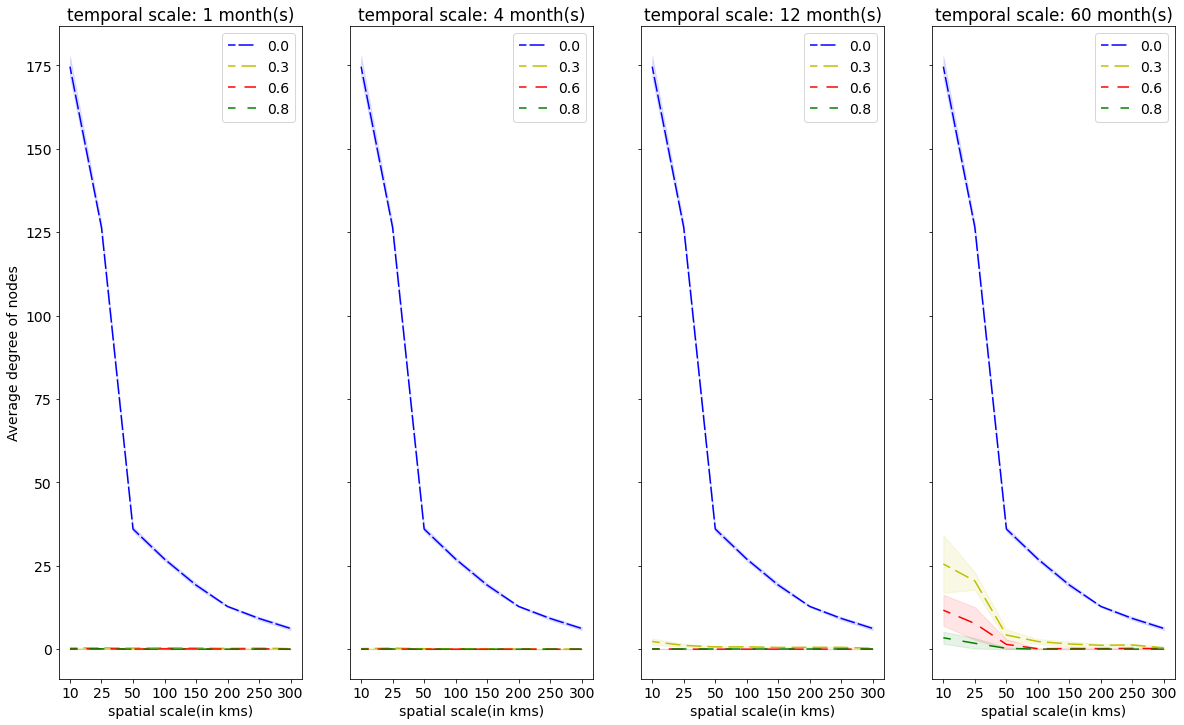

In [1058]:
plot_entropy_graph_analysis(evaluate_degree=True)

### Interesting pattern observed in all_closeness for transfer entropy data: closeness decrease as scale progresses but spikes up at scale=12 months and then fall to almost zero for 5 years.

In [124]:
def plot_heatmap(closeness_dict, spatial_scales, temporal_scales, mean=True):
    idx = 1 if not mean else 0
    stds = []
    for spatial_scale in spatial_scales:
        tmp = []
        for temporal_scale in temporal_scales:
            tmp.append(closeness_dict[(spatial_scale, temporal_scale)][idx])
        stds.append(tmp)
        
    stds = np.array(stds)
    stds = np.flip(stds, axis=0)
    
    default_x_ticks = range(len(temporal_scales))
    default_y_ticks = range(len(spatial_scales))

    plt.figure(figsize=(5,6))

    plt.xticks(default_x_ticks, temporal_scales)
    plt.yticks(default_y_ticks, spatial_scales[::-1])

    plt.xlabel("temporal scale")
    plt.ylabel("spatial scale")
    plt.imshow(stds)
    plt.savefig("../data/pictures/transfer_entropy_closeness_at_scales_{}.png".format("mean" if mean else "std"), bbox_inches='tight')

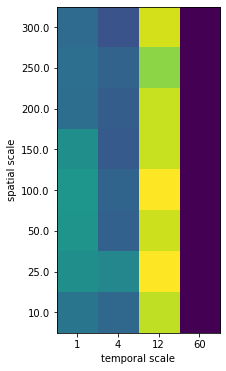

In [129]:
plot_heatmap(all_closeness_mean1, spatial_scales, temporal_scales)

In [126]:
plot_heatmap(all_closeness_mean2, spatial_scales, temporal_scales)

In [121]:
# plot_heatmap(all_closeness_mean1, spatial_scales, temporal_scales, mean=False)

ToDo:
# 0. Use new method to evaluate distance and transfer entropy correlation
1. Evaluate other network metrics
2. Plot steady state convergence of gdp(for different scales) for different tessellations. Plot all tessellations on one graph.
3. Some transfer entropy plots to show on the geographical map
4. Report

In [19]:
# cmap = cmap = plt.cm.get_cmap("Pastel1", len(chosen_sites))
# all_site_to_points = []
# all_colors = []
# idx_sites_to_plot = []
# for i, col in enumerate(sim_data["gdp_sum"].keys()):
#     tmp_site_to_points = list(tess_data["site_to_point_dict"][int(col)])
#     all_site_to_points.extend(tmp_site_to_points)
# #     
#     tmp_color = [cmap(i)]*len(tmp_site_to_points)
#     all_colors.extend(tmp_color)
#     idx_sites_to_plot.append(int(col))
    
    
# # all_site_to_points = np.array(all_site_to_points)
# # sites_to_plot = np.array(list(calculate_centroid_sites(tess_data, idx_sites_to_plot).values()))
# # # sites_to_plot = np.array([tess_data["sites"][i] for i in idx_sites_to_plot])
# # # sites_to_plot = np.array(tess_data["sites"])

# # fig, ax = plt.subplots(1,1, figsize=(5,7))
# # ax.scatter(all_site_to_points[:, 1], all_site_to_points[:, 0], c=all_colors)

# # ax.scatter(sites_to_plot[:, 1], sites_to_plot[:, 0], c='k')


In [600]:
a = {"1": 2, "2": 3}
for i, (key, item) in enumerate(a.items()):
    print(i, key, item)

0 1 2
1 2 3


In [708]:
def calculate_centroid_of_site(tess_data, idx_site):
    item = tess_data["site_to_point_dict"][idx_site]
    numerator_x = 0.0
    numerator_y = 0.0
    for point in item:
        numerator_x += point[1]
        numerator_y += point[0]

        centroid_x = np.floor(numerator_x/len(item))
        centroid_y = np.floor(numerator_y/len(item))

    return [centroid_y, centroid_x]


def plot_voronoi_tessellations(spatial_scale, seed, save=False):
    with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(spatial_scale, seed), "rb") as f:
        tess_data = pickle.load(f)
    
    plt.rc('font', size=14)
    fig, ax = plt.subplots(1,1,figsize=(6, 9))
    
    cmap = plt.cm.get_cmap("Pastel1", len(tess_data["site_to_point_dict"]))
    all_site_to_points, all_colors, all_sites_location = [], [], []
    for i, (key, item) in enumerate(tess_data["site_to_point_dict"].items()):
        all_sites_location.append(calculate_centroid_of_site(tess_data, key))
        tmp_site_to_points = list(item)
        all_site_to_points.extend(tmp_site_to_points)

        tmp_color = [cmap(i)]*len(tmp_site_to_points)
        all_colors.extend(tmp_color)
        
    all_site_to_points = np.array(all_site_to_points)
    all_sites_location = np.array(all_sites_location)
    
#     all_site_to_points = np.flip(all_site_to_points, axis=0)
#     all_sites_location = np.flip(all_sites_location, axis=0)
    ax.set_ylim((2100, 0))
    
    ax.scatter(all_site_to_points[:, 1], all_site_to_points[:, 0], c=all_colors)
    ax.scatter(all_sites_location[:, 1], all_sites_location[:, 0], c='k')
    ax.set_title("Spatial scale: {}".format(spatial_scale))
#     ax.plot()
    
    if save:
        plt.savefig("../data/pictures/voronoi_tessellation_{}.png".format(spatial_scale))



def plot_entropy_vs_distance_on_map(site_idx, tess_data, temporal_scales, spatial_scale, seed):
    fig, ax = plt.subplots(1,len(temporal_scales), figsize=(15, 7))
    
    for t, temporal_scale in enumerate(temporal_scales):
        transfer_entropy = pd.read_csv("../data/results/transfer_entropy/transfer_entropy_{}_{}_{}.csv".format(spatial_scale, temporal_scale, seed))
        transfer_entropy.set_index(transfer_entropy.columns, inplace=True)


        main_site = transfer_entropy.columns[site_idx]
        main_site_location = calculate_centroid_of_site(tess_data, int(main_site))
        
        abs_entropy = get_entropy(transfer_entropy.iloc[:, site_idx])
        
        if abs_entropy == 0.0:
            print("Absolute entropy of site:{} is zero. Not plotting for this site.".format(main_site))
            continue
        
        site_to_tf = {}
        site_locations = {}
        lines = []
        all_site_to_points = []
        all_colors = []

        cmap = plt.cm.get_cmap("Pastel1", len(transfer_entropy.columns))

        for i, col in enumerate(transfer_entropy.columns):
            if i == main_site:
                continue
            else:
                tmp_site_to_points = list(tess_data["site_to_point_dict"][int(col)])
                all_site_to_points.extend(tmp_site_to_points)

                tmp_color = [cmap(i)]*len(tmp_site_to_points)
                all_colors.extend(tmp_color)
                
                new_tf = 100.0*transfer_entropy[col][main_site]/abs_entropy
                
                site_to_tf[col] = new_tf
                new_site_location = calculate_centroid_of_site(tess_data, int(col))
                site_locations[col] = new_site_location

                lines.append([[main_site_location[0], new_site_location[0]], [main_site_location[1], new_site_location[1]], new_tf/10.0])

        all_site_to_points = np.array(all_site_to_points)


        a = np.array(list(site_locations.values()))
        ax[t].scatter(a[:, 1], a[:, 0])
        ax[t].set_xlim((0, 1563))
        ax[t].set_ylim((0, 2012))
        for line in lines:
            ax[t].plot(line[1], line[0], linewidth = line[2], alpha=0.7)

        ax[t].scatter(all_site_to_points[:, 1], all_site_to_points[:, 0], c=all_colors)
        ax[t].set_title("Spatial: {}, temporal: {}".format(spatial_scale, temporal_scale))
    

In [709]:
for spatial_scale in spatial_scales:
    plot_voronoi_tessellations(spatial_scale, 1, save=True)

Error in callback <function flush_figures at 0x7f4d7faae3a0> (for post_execute):


KeyboardInterrupt: 

In [7]:
# spatial_scale = 150.0
# seed = 1
# temporal_scales = [1,4,12,60]

# with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(spatial_scale, seed), "rb") as f:
#     tess_data = pickle.load(f)
    
# with open("../data/sims/1992_10_radius-{}_seed-{}.pkl".format(spatial_scale, seed), "rb") as f:
#     sim_data = pickle.load(f)
    
# print("Num sites: ", len(sim_data["gdp_sum"]))

In [5]:
# for site_idx in np.arange(len(sim_data["gdp_sum"].keys())):
#     for temporal_scale in temporal_scales:
#         transfer_entropy = pd.read_csv("../data/results/transfer_entropy/transfer_entropy_{}_{}_{}.csv".format(spatial_scale, temporal_scale, seed))
#         transfer_entropy.set_index(transfer_entropy.columns, inplace=True)
        
#         print("{}_{}".format(site_idx, temporal_scale))
#         print(get_entropy(transfer_entropy.iloc[:, site_idx]))
#         print("_"*10)
        

In [582]:
spatial_scale = 50.0
seed = 1
temporal_scales = [1,4,12,60]

with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(spatial_scale, seed), "rb") as f:
    tess_data = pickle.load(f)
    
with open("../data/sims/1992_10_radius-{}_seed-{}.pkl".format(spatial_scale, seed), "rb") as f:
    sim_data = pickle.load(f)
    
print("Num sites: ", len(sim_data["gdp_sum"]))

Num sites:  38


In [585]:
tess_data["site_to_point_dict"].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [6]:
for site_idx in np.arange(len(sim_data["gdp_sum"].keys())):
    plot_entropy_vs_distance_on_map(site_idx, tess_data, temporal_scales, spatial_scale, seed)

NameError: name 'pickle' is not defined

Absolute entropy of site:1 is zero. Not plotting for this site.
Absolute entropy of site:2 is zero. Not plotting for this site.
Absolute entropy of site:4 is zero. Not plotting for this site.
Absolute entropy of site:6 is zero. Not plotting for this site.
Absolute entropy of site:7 is zero. Not plotting for this site.
Absolute entropy of site:8 is zero. Not plotting for this site.
Absolute entropy of site:9 is zero. Not plotting for this site.
Absolute entropy of site:10 is zero. Not plotting for this site.
Absolute entropy of site:11 is zero. Not plotting for this site.
Absolute entropy of site:14 is zero. Not plotting for this site.
Absolute entropy of site:15 is zero. Not plotting for this site.
Absolute entropy of site:18 is zero. Not plotting for this site.
Absolute entropy of site:19 is zero. Not plotting for this site.


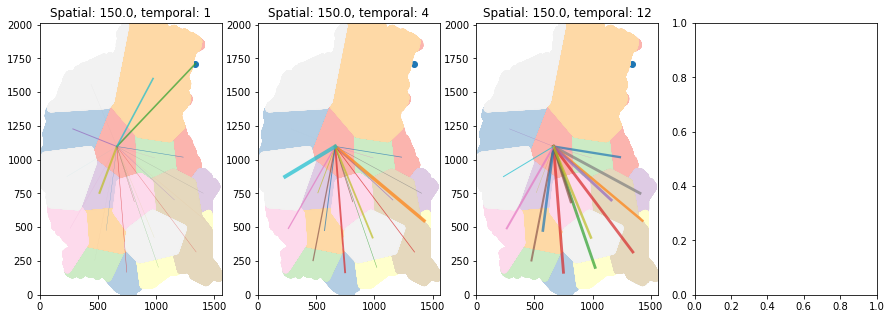

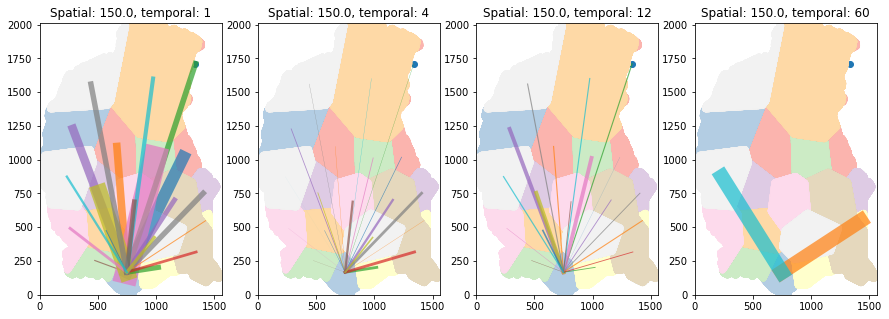

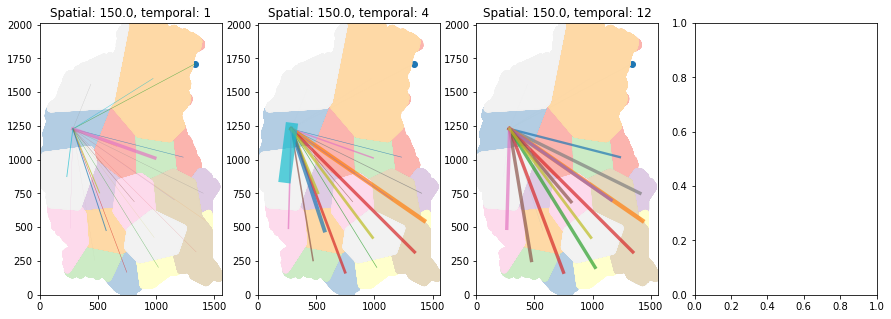

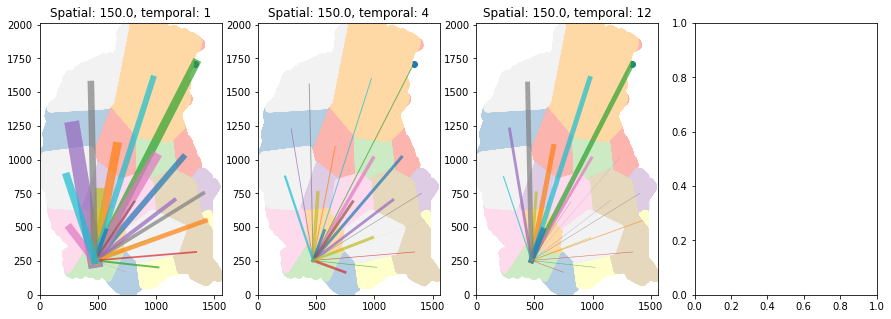

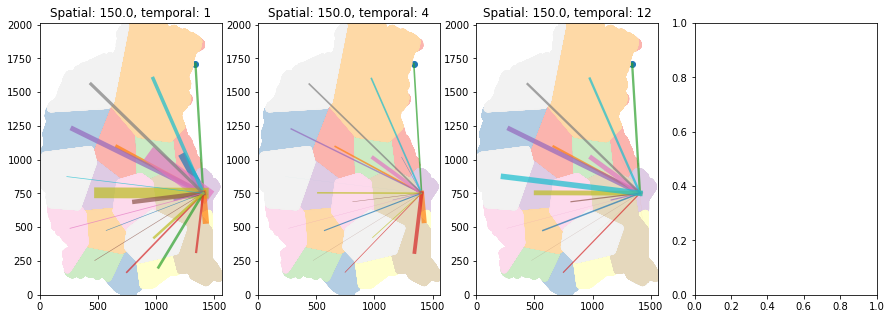

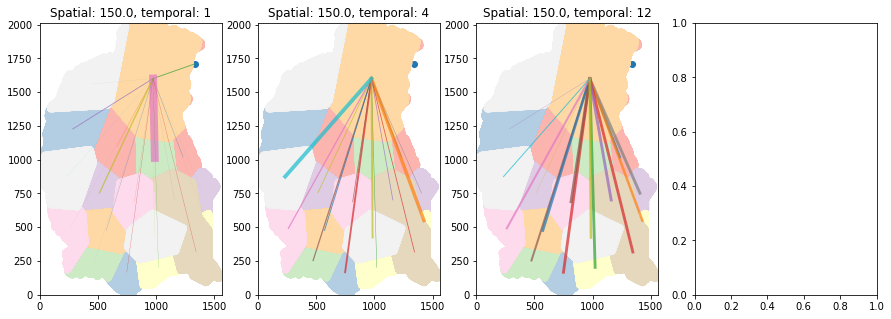

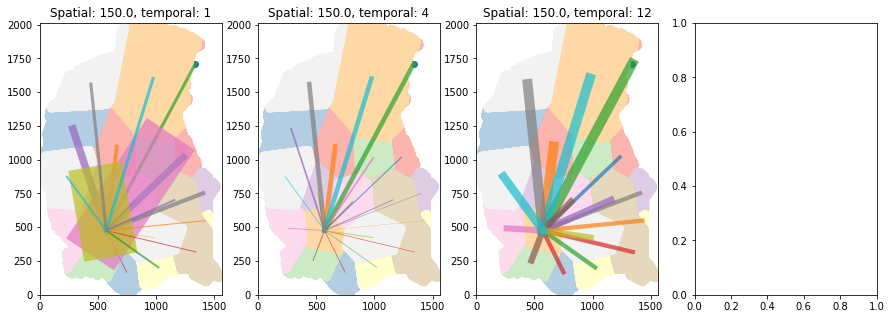

Error in callback <function flush_figures at 0x7f0f9e0c2280> (for post_execute):


In [ ]:
spatial_scale = 150.0
seed = 1
temporal_scales = [1,4,12,60]

with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(spatial_scale, seed), "rb") as f:
    tess_data = pickle.load(f)
    
with open("../data/sims/1992_10_radius-{}_seed-{}.pkl".format(spatial_scale, seed), "rb") as f:
    sim_data = pickle.load(f)
    
print("Num sites: ", len(sim_data["gdp_sum"]))

for site_idx in np.arange(len(sim_data["gdp_sum"].keys())):
    plot_entropy_vs_distance_on_map(site_idx, tess_data, temporal_scales, spatial_scale, seed)

In [326]:
# def get_sims_data(radius, seed, tessellation_data):    
#     columns = None
#     data_dict = {}
    
#     missing_pop_count = {}
    
#     year_range = np.arange(1992, 2022, 1)
#     for year in tqdm(year_range):
#         month_range = np.arange(4, 13, 1) if year == 1992 else np.arange(1, 13, 1)
#         for month in tqdm(month_range):
#             filename = "../data/sims/{}_{}_radius-{}_seed-{}.pkl".format(year, month, radius, seed)
#             if not os.path.exists(filename):
#                 data_dict["{}_{}".format(year, month)] = []
#             else:
#                 with open(filename, "rb") as f:
#                     data = pickle.load(f)

#                 keys = set(list(data["gdp_sum"].keys()))
#                 tmp = []
#                 for key in keys:
#                     # if key in tessellation_data[(radius, seed)]["site_to_point_dict"]:
#                     if data["site_pop_sum"][key] == 1.0:
# #                         print("key missing: ", key)
#                         pop_sum = 1.0
# #                         pop_sum = get_missing_pop_count(tessellation_data, year, month, radius, seed, key)
#                     else:
#                         pop_sum = data["site_pop_sum"][key]
                        
#                     tmp.append(round(data["gdp_sum"][key]/pop_sum, 2))

#                 data_dict["{}_{}".format(year, month)] = tmp
                
#         print("year {} done".format(year))
#     df = pd.DataFrame.from_dict(data_dict).transpose()
#     df.columns = keys
#     return df

In [327]:
# with open("../data/voronoi_tessellation_meta_{}_{}.pkl".format(10.0, 1), "rb") as f:
#     tess_data = pickle.load(f)
    
# df = get_sims_data(10.0, 1, tess_data)

1. Change names of columns in gdp.csv, events.csv, transfer_entropy.csv

In [329]:
# def get_new_column_names(spatial_scales, seeds):
#     column_names_dict = {}
#     for spatial_scale in spatial_scales:
#         for seed in seeds:
#             filename = "../data/sims/{}_{}_radius-{}_seed-{}.pkl".format(1992, 4, spatial_scale, seed)
#             with open(filename, "rb") as f:
#                 data = pickle.load(f)
#                 keys = set(list(data["gdp_sum"].keys()))
#             column_names_dict["{}_{}".format(spatial_scale, seed)] = keys
#     return column_names_dict

In [330]:
# column_names_dict = get_new_column_names(spatial_scales, seeds)
# column_names_dict["150.0_1"]

In [328]:
# def change_gdp_columns(column_names_dict, save=False):
#     for file in glob("../data/results/*"):
#         if "gdp_" and ".csv" in file:
#             df = pd.read_csv(file)
#             tmp = file.split("/")[-1].split("_")
#             spatial_scale = tmp[1]
#             seed = tmp[-1].split(".csv")[0]
#             new_col_names = sorted(list(column_names_dict["{}_{}".format(spatial_scale, seed)]))
#             new_col_names.insert(0, df.columns[0])
#             df.columns = new_col_names
#             if save:
#                 df.to_csv(file, index=False)
            
# # def change_events_columns(column_names_dict, save=False):
# #     for file in glob("../data/results/events/*"):
# #         print(file)
# #         df = pd.read_csv(file)
# #         tmp = file.split("/")[-1].split("_")
# #         spatial_scale, seed = tmp[1], tmp[3]
        
# #         new_col_names = sorted(list(column_names_dict["{}_{}".format(spatial_scale, seed)]))
# #         new_col_names.insert(0, df.columns[0])
# #         print(new_col_names)
# #         df.columns = new_col_names
        
# #         if save:
# #             df.to_csv(file, index=False)
        

In [1547]:
# change_events_columns(column_names_dict, save=True)

In [277]:
all_closeness_mean1

{(10.0, 1): (5.024425575156284, 2.5463725567416313),
 (10.0, 4): (4.291004469646639, 2.187164450515417),
 (10.0, 12): (11.635121961135336, 5.836708481275194),
 (10.0, 60): (0.002860771904458562, 0.0009596516833390743),
 (25.0, 1): (6.386878279217846, 0.43145753996841707),
 (25.0, 4): (5.938971289610857, 1.5969923954787217),
 (25.0, 12): (12.840488089124563, 1.3004346091417318),
 (25.0, 60): (0.003087218024075934, 0.00019620950429263646),
 (50.0, 1): (6.670979225283242, 1.0763011049743434),
 (50.0, 4): (4.021061258123359, 0.4089669007377783),
 (50.0, 12): (11.887376726583659, 0.626482792756266),
 (50.0, 60): (0.003066197531322744, 0.0010692020096570427),
 (100.0, 1): (6.766921465184081, 1.173559244852247),
 (100.0, 4): (4.16964578179429, 0.6098567771974798),
 (100.0, 12): (12.864018816379295, 1.035878946222555),
 (100.0, 60): (0.002626066644690154, 0.0008521322063356929),
 (150.0, 1): (6.383416308329925, 1.9455701284677334),
 (150.0, 4): (3.6206111386768796, 0.3304945251817918),
 (150.0

In [283]:
df_data = []
for radius in all_radius:
    tmp = []
    for temporal in all_temporal:
        tmp.append(round(all_closeness_mean1[(radius, temporal)][0], 2))
    df_data.append(tmp)
    
df = pd.DataFrame(df_data, columns=[all_temporal])
df.index = all_radius

In [284]:
df.to_csv("../data/entropy_based_closeness_events_data.csv")

In [285]:
plt.imshow(pd.read_csv("../data/"))

1     4      12   60
10.0   5.02  4.29  11.64  0.0
25.0   6.39  5.94  12.84  0.0
50.0   6.67  4.02  11.89  0.0
100.0  6.77  4.17  12.86  0.0
150.0  6.38  3.62  11.80  0.0
200.0  4.67  3.81  11.80  0.0
250.0  4.68  4.11  10.63  0.0
300.0  4.50  3.27  12.04  0.0

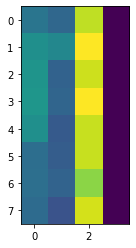

In [357]:
plt.imshow(np.array(pd.read_csv("../data/entropy_based_closeness_events_data.csv").iloc[:, 1:]))

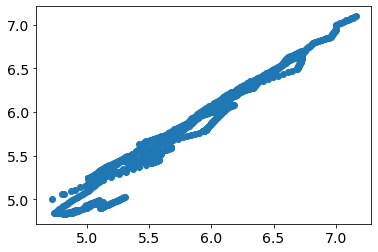

In [913]:
x = list(predicted_gdp_df["log_gdp"])
y = list(predicted_gdp_df["log_gdp_revised"])

plt.scatter(x, y)

(4.5, 7.0)

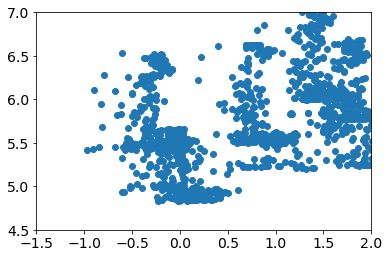

In [902]:
predicted_gdp_df = pd.read_csv("../data/revised_gdp_dmsp_ols_monthly.csv")
y1 = list(predicted_gdp_df["log_gdp_revised"])
plt.scatter(predicted_gdp_df["log_ntl"], y1)
plt.xlim((-1.5, 2))
plt.ylim((4.5, 7.0))

In [890]:
# sns.kdeplot(y1, linestyle="--")

In [891]:
predicted_gdp_df = pd.read_csv("../data/revised_gdp_viirs_monthly.csv")
y2 = list(predicted_gdp_df["log_gdp_revised"])
plt.scatter(predicted_gdp_df["log_ntl"], y2)
plt.xlim((-8, 0.5))
plt.ylim((0, 8.5))

(0.0, 8.5)

<AxesSubplot:ylabel='Density'>

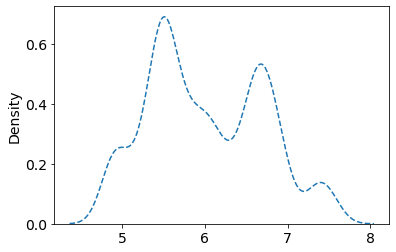

In [892]:
y1.extend(y2)
sns.kdeplot(y1, linestyle="--")

In [904]:
combined_df = pd.read_csv("../data/imf_data_combined_dmsp_ols_monthly.csv")
x, y1 = [], []
for year in range(1992, 2013):
    if year == 1992:
        month_range = np.arange(4, 13, 1)
    else:
        month_range = np.arange(1, 13, 1)
        
    for month in month_range:
        [x.append(np.log(val)) for val in combined_df["gdp_{}_{}".format(year, month)]]
        [y1.append(np.log(val)) for val in combined_df["rescaled_calibrated_ntl_sum_per_capita_{}_{}".format(year, month)]]
        
plt.scatter(x, y1)
plt.xlim(4, 16.5)

(4.0, 16.5)

In [898]:
# sns.kdeplot(y, linestyle="--")

(5.0, 25.0)

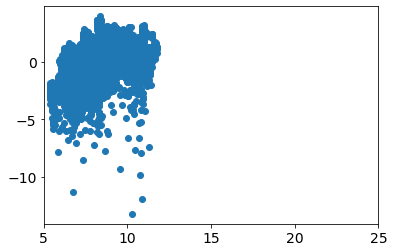

In [899]:
combined_df = pd.read_csv("../data/imf_data_combined_viirs_monthly.csv")
x, y2 = [], []
for year in range(2013, 2022):
    if year == 1992:
        month_range = np.arange(4, 13, 1)
    else:
        month_range = np.arange(1, 13, 1)
        
    for month in month_range:
        [x.append(np.log(val)) for val in combined_df["gdp_{}_{}".format(year, month)]]
        [y2.append(np.log(val)) for val in combined_df["rescaled_calibrated_ntl_sum_per_capita_{}_{}".format(year, month)]]
        
plt.scatter(x, y2)
plt.xlim(5, 25.0)

<AxesSubplot:ylabel='Density'>

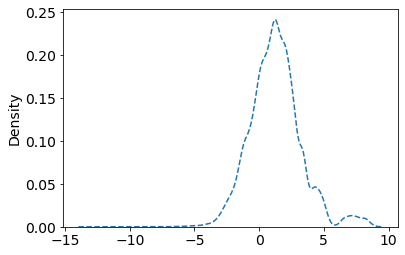

In [900]:
y1.extend(y2)
sns.kdeplot(y1, linestyle="--")